In [1]:
import glob 
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from sklearn.cluster import DBSCAN
import numpy as np

In [2]:
varproteinsdir = "/n/data1/hms/dbmi/baym/arya/projects/genscale_work/experiments/prefsuff_kmermatching/001_implementsmkpipeline/data/mtbc-highquality/prefsuff-kmermatching/variableproteins"
distances = glob.glob(os.path.join(varproteinsdir, "*", "collated_fastmap_dists"))

In [23]:
# print(os.path.join("*", "collated_fastmap_dists"))
# print(distances)

In [24]:
# pd.read_csv('./variableproteins/GCF_028583265.1_01195/collated_fastmap_dists', sep='\t')

In [3]:
def cluster_collated_fastmaps(collated_dists, eps=800, min_samples=3):
    df = pd.read_csv(collated_dists, sep='\t',
                  names=["GENOME","KMER","Prefix","Suffix","Case"])
    df['GENOME'] = df['GENOME'].str.split('/', expand=True)[3].str.split(':', expand=True)[1]
    # Convert the 'Case' column to string for string operations
    df['Case'] = df['Case'].astype(str)
    
    # Create a default 'Cluster' column with -1 values
    df['Cluster'] = -1
    
    # Filter data for DBSCAN
    valid_data = df[~df['Case'].str.contains('missing')]

    # Convert the 'Case' column of valid_data to float first, then integer
    valid_data.loc[:, 'Case'] = valid_data['Case'].astype(float)
    
    # Reshape data for DBSCAN
    X = np.array(valid_data['Case']).reshape(-1, 1)    

    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    
    # Update labels to dataframe for valid data
    df.loc[~df['Case'].str.contains('missing'), 'Cluster'] = db.labels_

    df['Distances'] = -1
    df.loc[:, 'Distances'] = valid_data['Case'].astype(float)
    df.loc[:, 'Cluster'] = df['Cluster'].astype(str)
    return df

def has_multiple_clusters(df):
    unique_clusters = df['Cluster'].unique()
    # Remove -1 (noise) from unique clusters
    unique_clusters = unique_clusters[unique_clusters != '-1']
    return len(unique_clusters) >= 2

def has_tight_clusters(df, threshold=500):
    clusters = df['Cluster'].unique()
    for cluster in clusters:
        if cluster != '-1': # Ignore noise cluster
            cluster_std = df[df['Cluster'] == cluster]['Distances'].astype(float).std()
            if cluster_std > threshold:
                return False
    return True

def has_large_intercluster_distance(df, threshold=1000):
    clusters = df['Cluster'].unique()
    centroids = []
    for cluster in clusters:
        if cluster != '-1': # Ignore noise cluster
            centroid = df[df['Cluster'] == cluster]['Distances'].astype(float).mean()
            centroids.append(centroid)
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            if abs(centroids[i] - centroids[j]) < threshold:
                return False
    return True

In [4]:
distance_dfs = {}
for i in distances:
    protein = os.path.dirname(i)
    protein = protein.split('/')[-1]
    # print(protein)
    df = cluster_collated_fastmaps(i)
    distance_dfs[protein] = df

In [5]:
def identify_interesting_dfs(df_dict):
    # interesting_dfs = {
    #     'multiple_clusters': [],
    #     'tight_clusters': [],
    #     'large_intercluster': []
    # }
    interesting_dfs = {}
    for protein in df_dict:
        df = df_dict[protein]
        if has_multiple_clusters(df) and has_tight_clusters(df) and has_large_intercluster_distance(df):
            interesting_dfs[protein] = (df)
    return interesting_dfs

def plot_violin(df, protein_name):
    # Filter out rows with Cluster == -1
    df = df[df['Cluster'] != '-1']

    # Plot the violinplot
    plt.figure(figsize=(10, 6))
    sns.violinplot(y='Distances', x='Cluster', data=df)
    # sns.stripplot(y='Distances', x='Cluster', data=df)
    
    plt.ylim(0, df['Distances'].max() + (0.05 * df['Distances'].max()))
    # Add title and labels
    plt.title("Genomic distances across clusters - %s" % protein_name)
    plt.xlabel("Cluster Assignment")
    plt.ylabel("Genomic distances between k-mers (bp)")
    
    # Display the plot
    plt.show()

In [6]:
interesting_dfs_dict = identify_interesting_dfs(distance_dfs)
print(len(interesting_dfs_dict))

24


In [8]:
for i in interesting_dfs_dict:
    print(i)

GCF_028583265.1_01195
GCF_028583265.1_01190
N1202_10380
GCF_028583265.1_06705
GCF_028583185.1_17505
02_R1896_09490
M0011368_9_08005
M0003941_3_18230
DNA188_12475
N1176_18205
GCF_028583185.1_09340
GCF_028583205.1_08040
02_R1179_14775
N1202_06025
M0014888_3_08275
GCF_028583225.1_11065
N1272_07795
02_R1708_17665
N1274_07335
DNA028_17740
GCF_028583245.1_07340
DNA019_Rose_19165
02_R1896_12480
N1177_17365


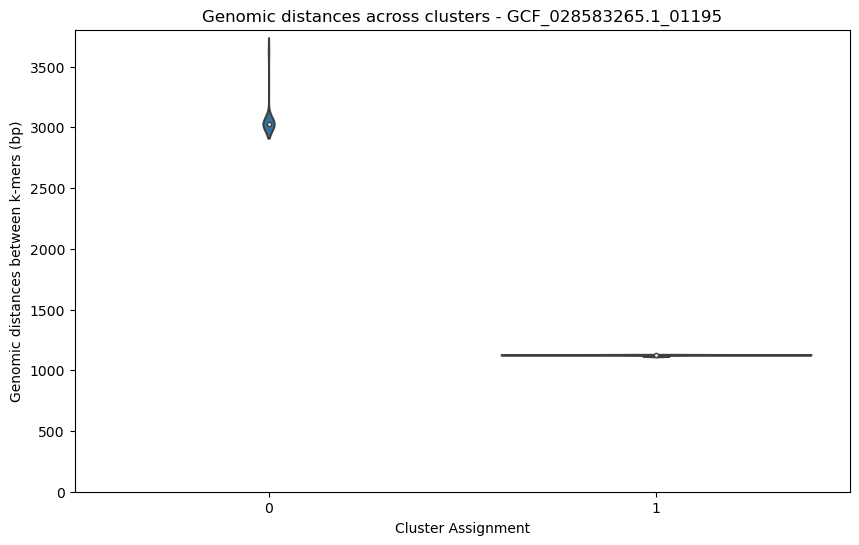

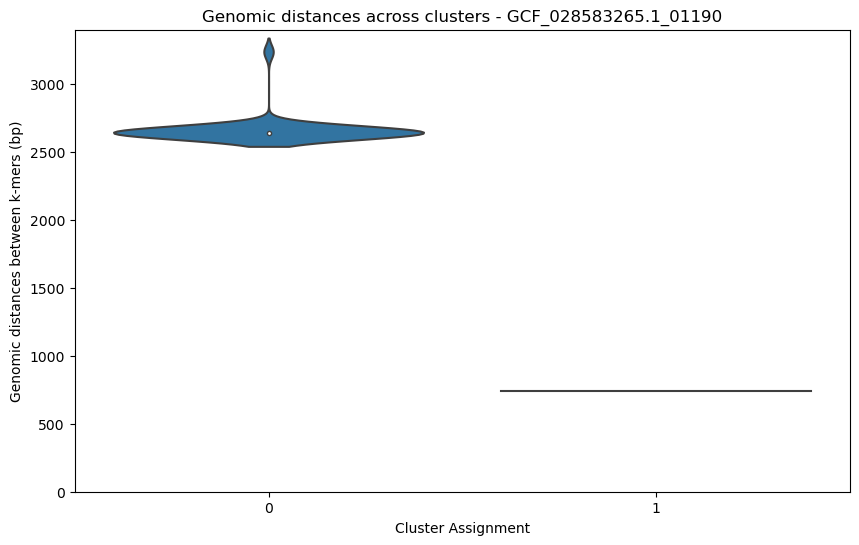

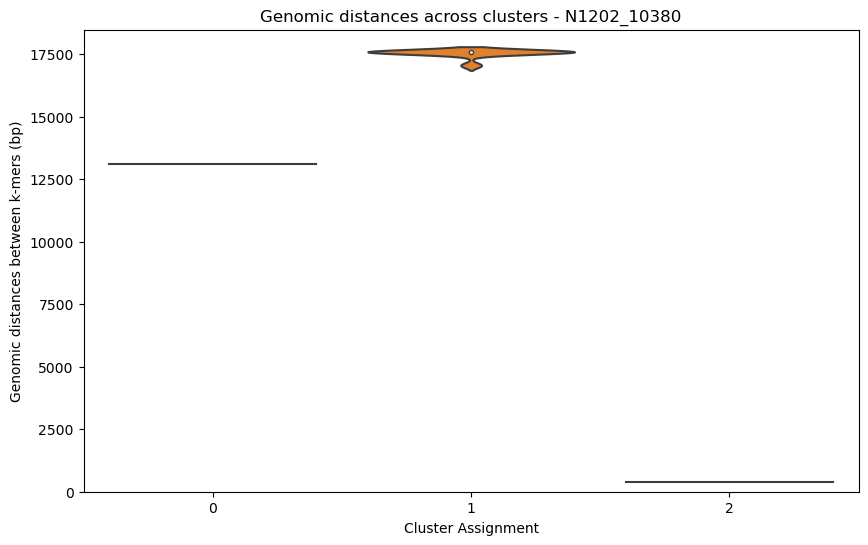

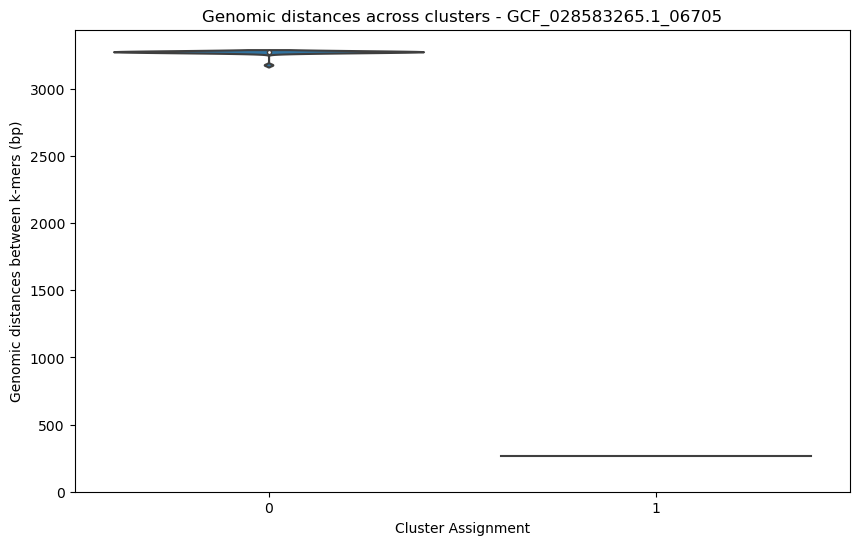

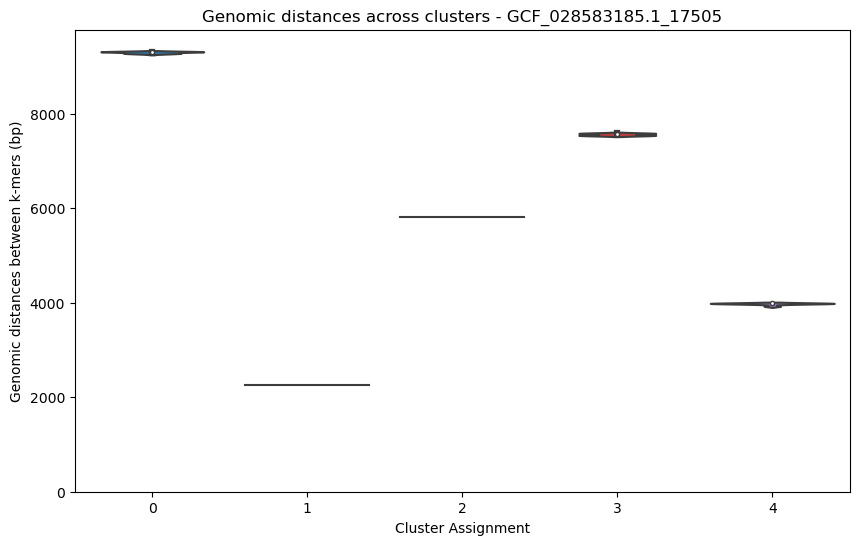

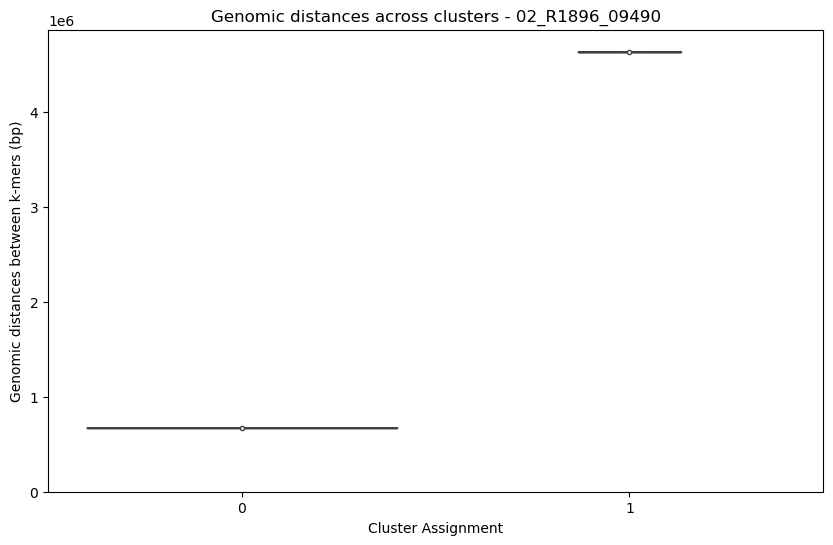

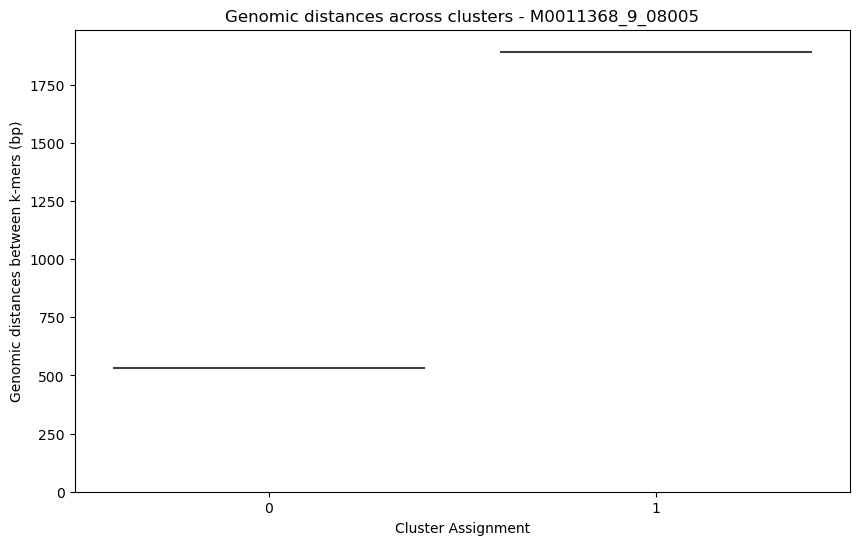

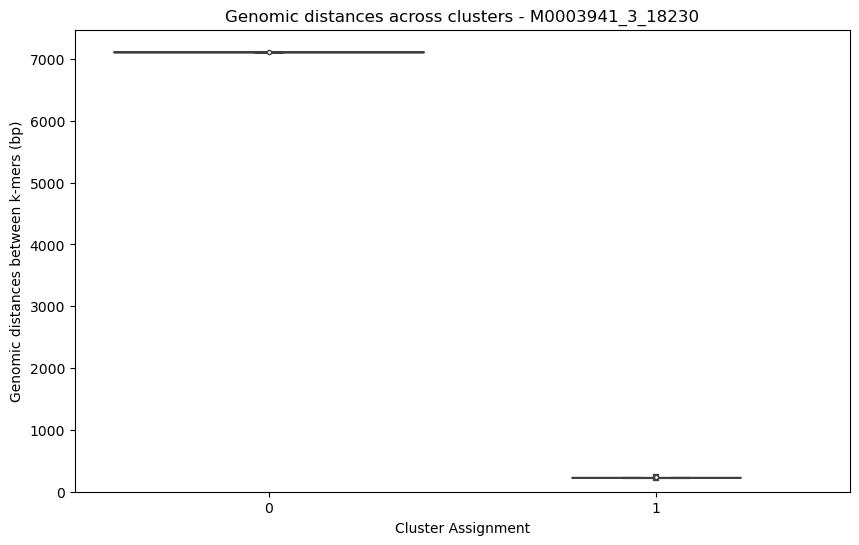

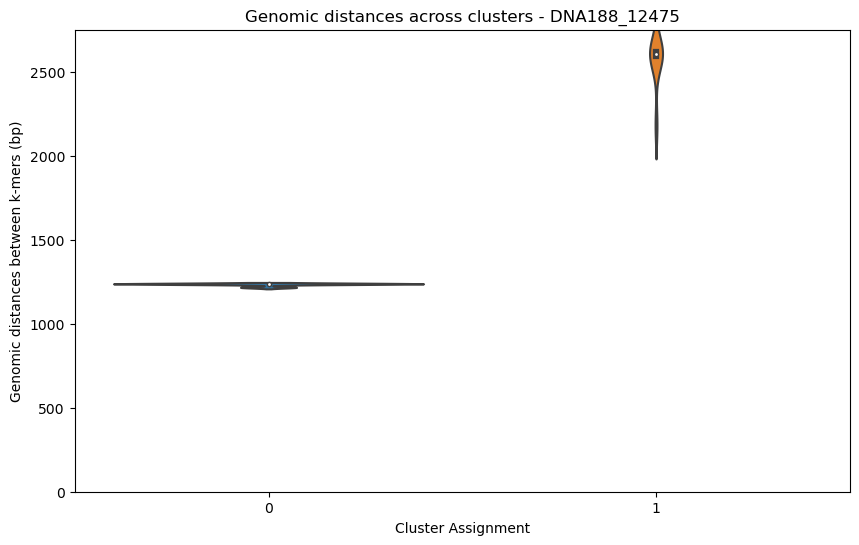

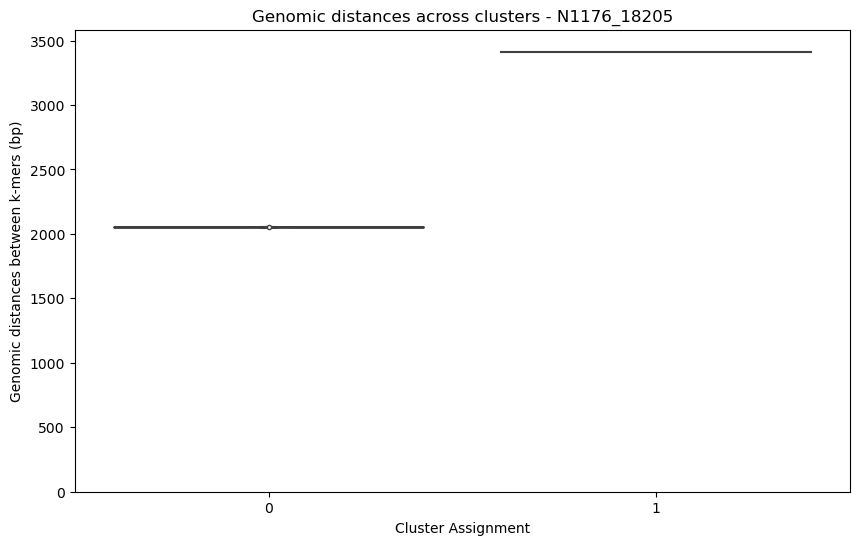

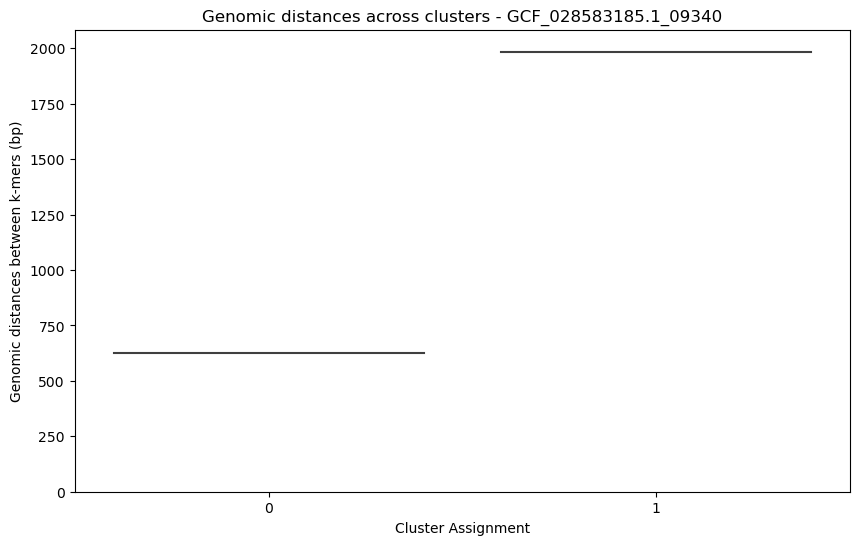

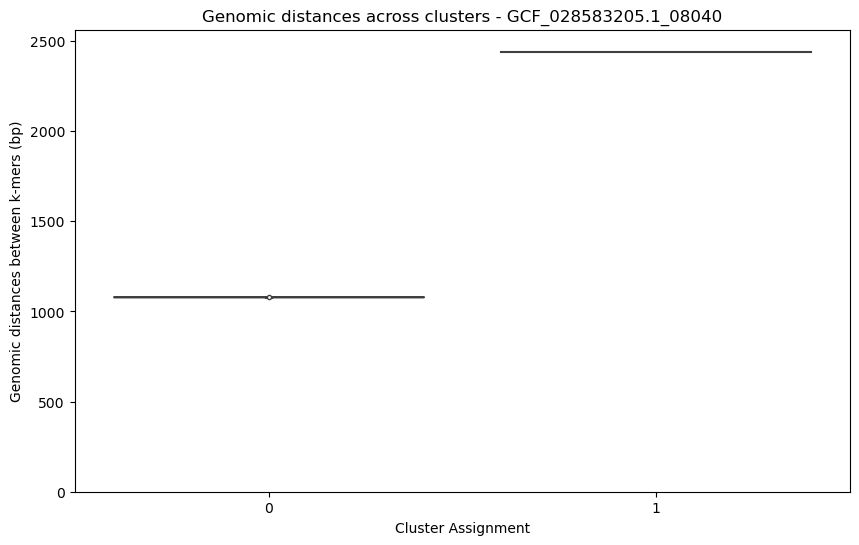

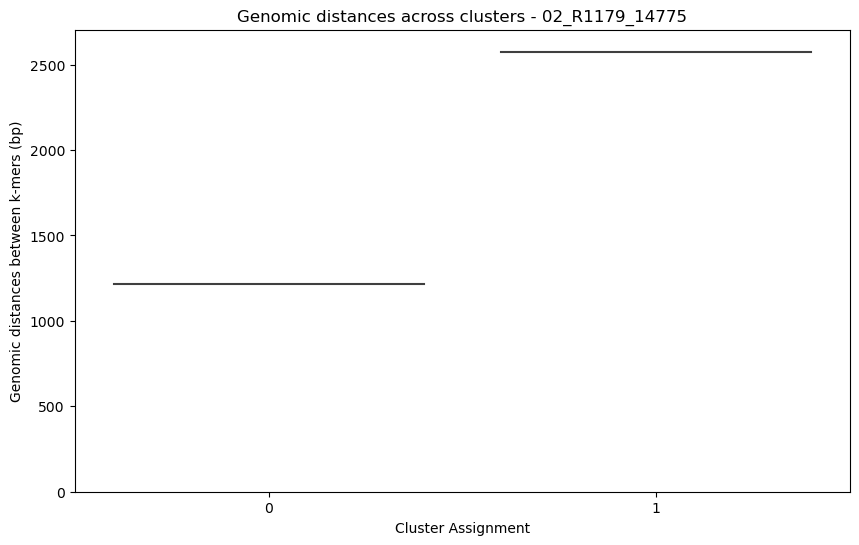

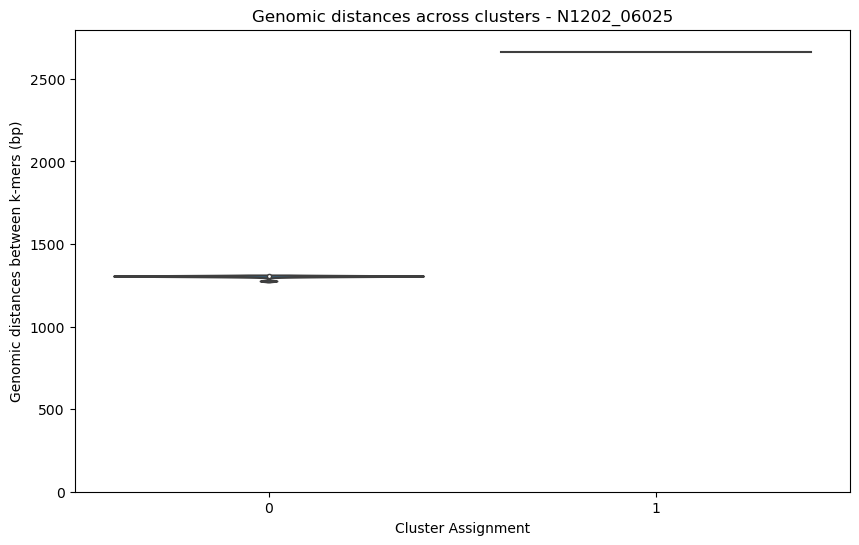

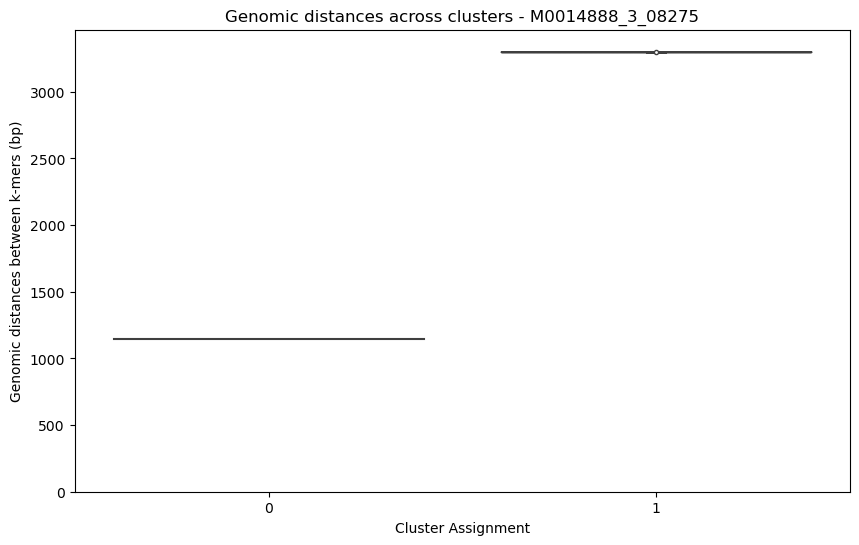

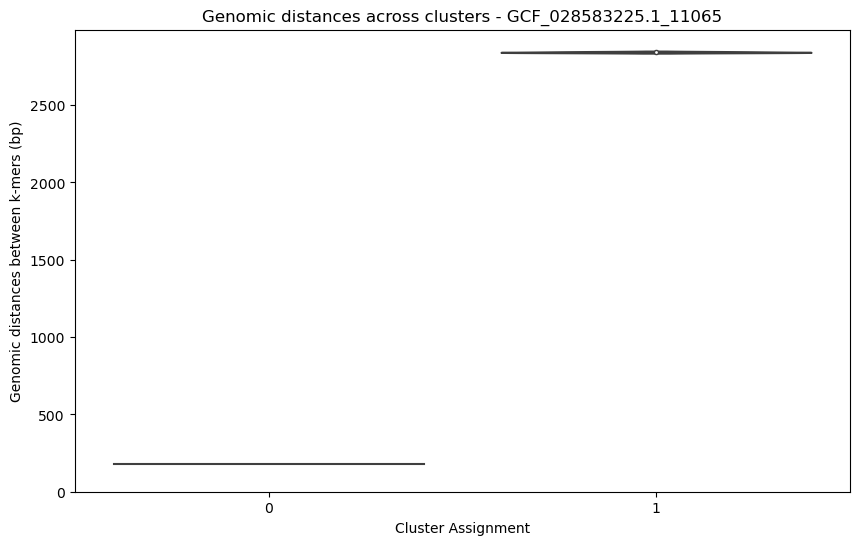

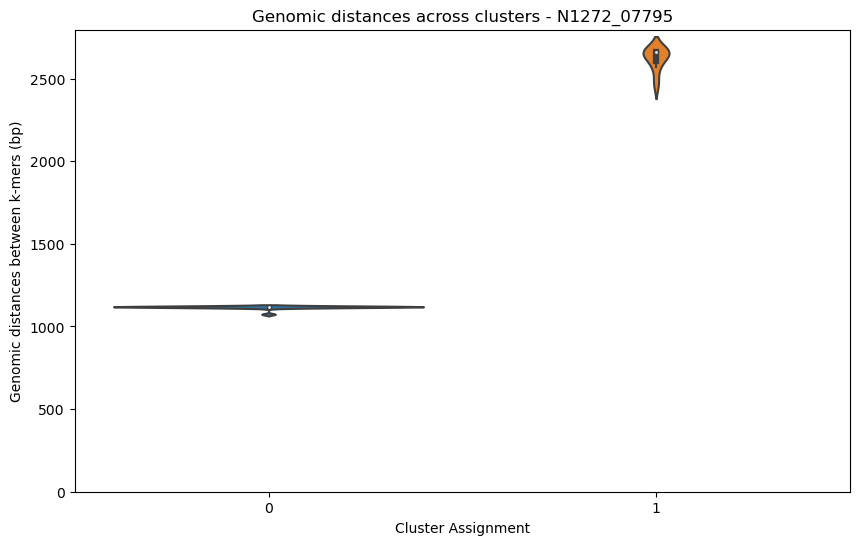

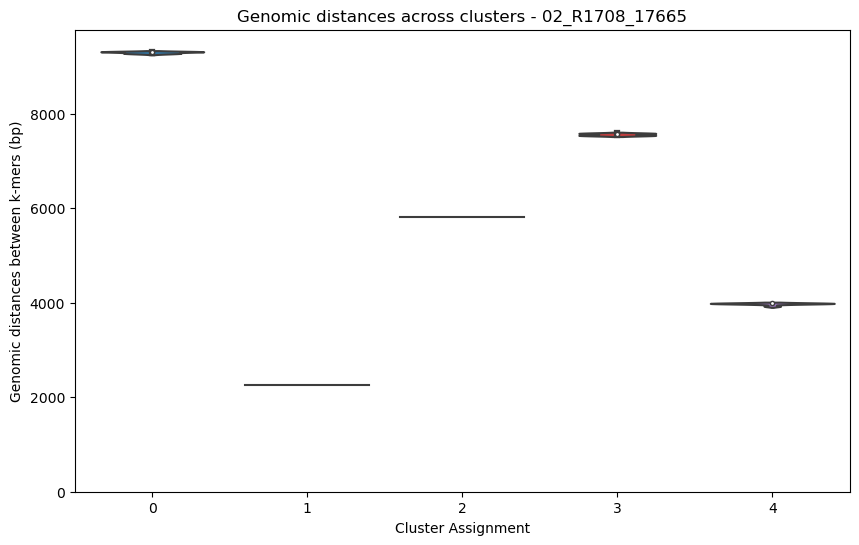

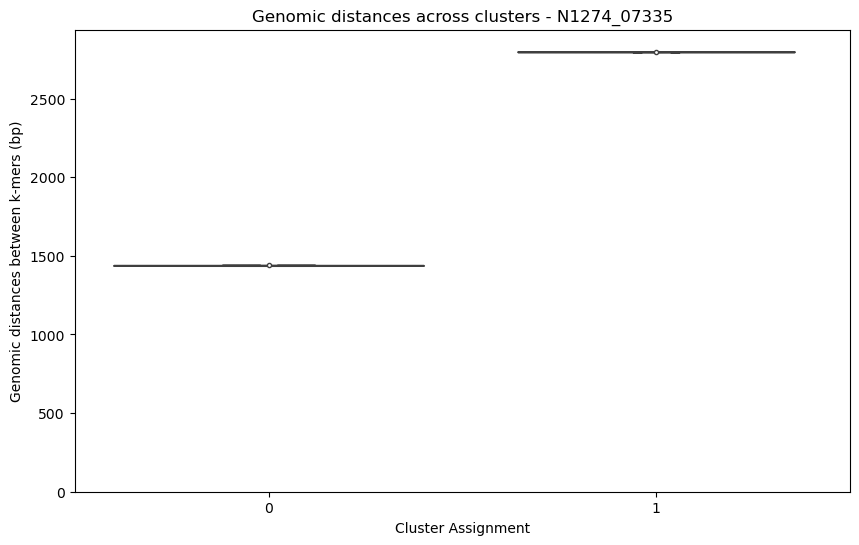

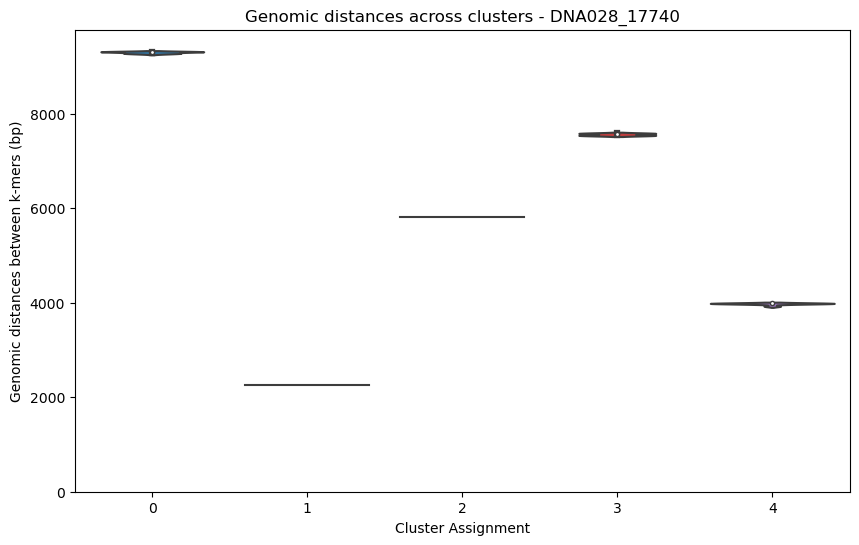

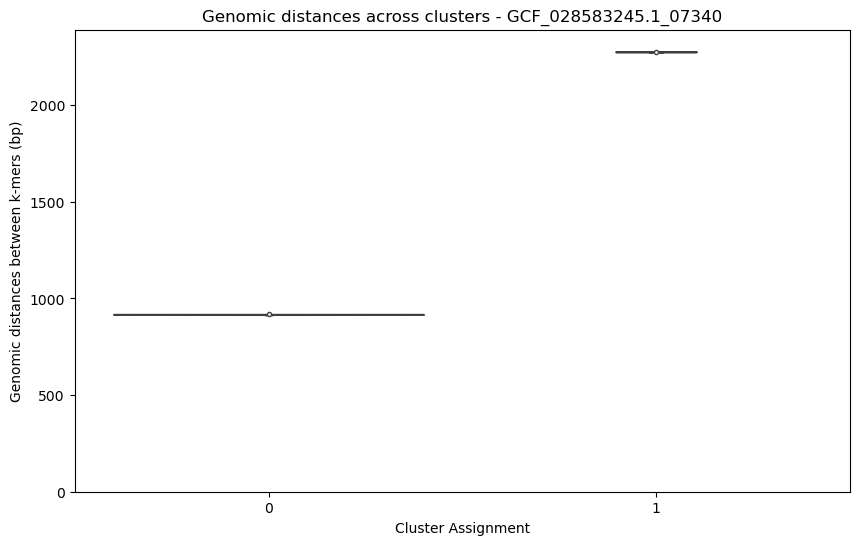

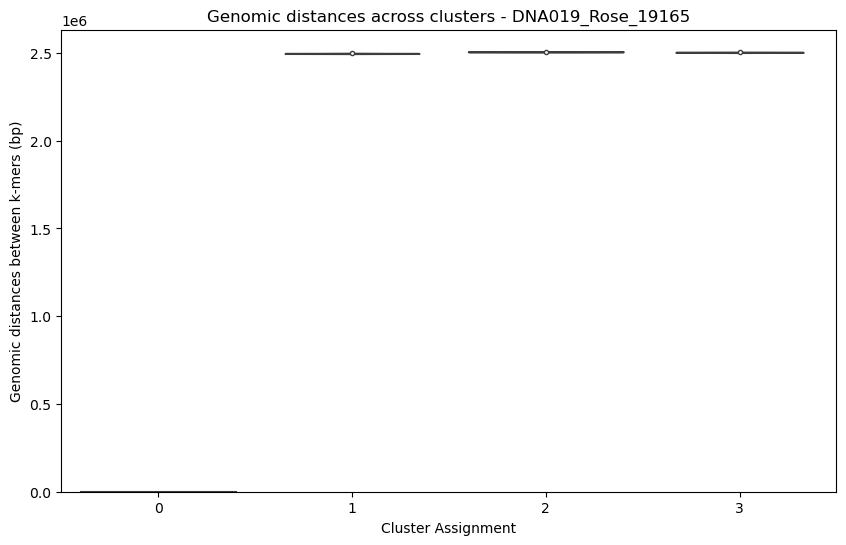

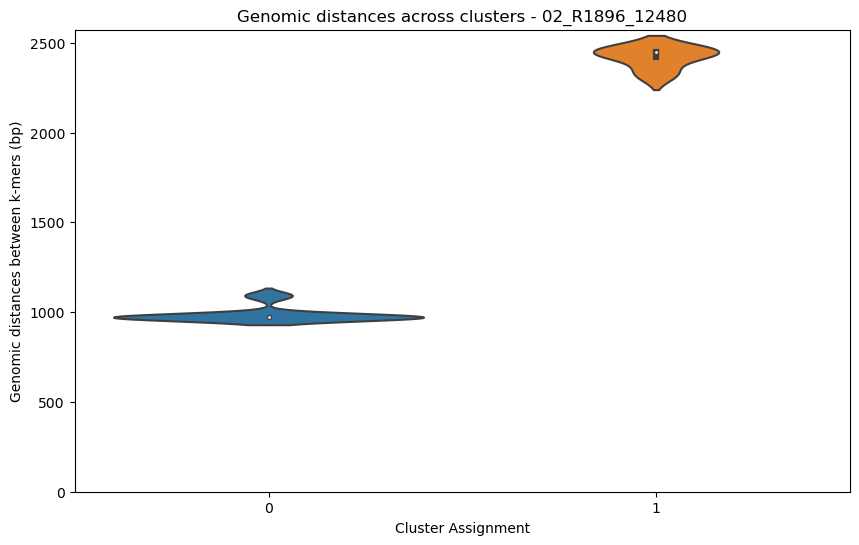

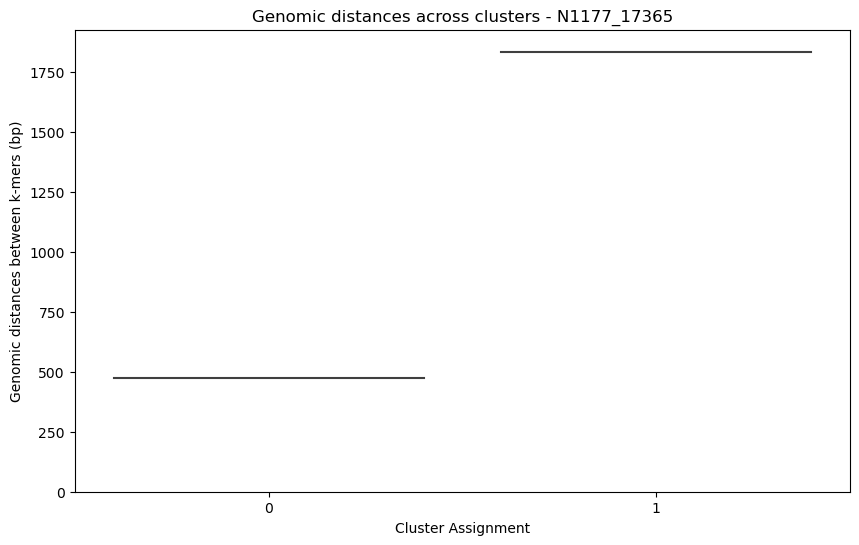

In [29]:
for proteins in interesting_dfs_dict:
    plot_violin(interesting_dfs_dict[proteins], proteins)

In [14]:
for i in interesting_dfs_dict:
    print(interesting_dfs_dict[i])

             GENOME                                               KMER   
0          01_R1134  prefix_kmer_GCF_028583265.1_01195_coordinates_...  \
1          01_R1430  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
2          02_R0894  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
3          02_R1179  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
4          02_R1708  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
5          02_R1896  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
6        AZE_02_042  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
7       DNA019_Rose  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
8            DNA020  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
9            DNA028  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
10           DNA044  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
11           DNA075  prefix_kmer_GCF_028583265.1_01195_coordinates_...   
12           DNA086  prefix_kmer_GCF_0

In [31]:
interesting_dfs_dict['GCF_028583225.1_11065']['Cluster'].unique()

array(['0', '-1', '1'], dtype=object)

In [9]:
import dna_features_viewer
from Bio import SeqIO
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord

class MyCustomTranslator(BiopythonTranslator):
    def compute_feature_color(self, feature):
        if feature.type == "CDS":
            return sns.color_palette("deep")[0]
        elif feature.type == "repeat_region":
            return sns.color_palette("deep")[0]
        elif feature.type == "mobile_element":
            return sns.color_palette("deep")[3]
        else:
            return sns.color_palette("deep")[2]
    
    def compute_feature_label(self, feature):
        return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_filtered_features(self, features):
        null_list = ["source", "gene", "dnaA"]
        passing = []
        for feature in features:
            if feature.type in null_list:
                continue
            else:
                passing.append(feature)
        return passing

def filter_features(record, excluded_names):
    """Return a new record without features with names in excluded_names."""
    new_record = record.__class__(record.seq)
    for feature in record.features:
        if feature.type == "CDS" and 'gene' in feature.qualifiers:
            gene_name = feature.qualifiers['gene'][0]
            if gene_name not in excluded_names:
                new_record.features.append(feature)
        else:
            new_record.features.append(feature)
    return new_record

In [15]:
def extract_plots(df, protein):
    base_annot_dir='/n/data1/hms/dbmi/baym/arya/projects/genscale_work/experiments/prefsuff_kmermatching/001_implementsmkpipeline/data/mtbc-highquality/assemblies/'
    unique_clusters = df['Cluster'].unique()
    genome = ''.join(protein.split('_')[:-1])
    # print(genome)
    gbk = os.path.join(base_annot_dir, genome, "annotation", genome + ".gbff")
    for clusternum in unique_clusters:
        if clusternum == '-1': continue
        rep = df[df['Cluster'] == clusternum].iloc[0]
        gbk = os.path.join(base_annot_dir, rep['GENOME'], "annotation", rep['GENOME'] + ".gbff")
        prefix = int(rep['Prefix'].split(':')[-1])
        suffix = int(rep['Suffix'].split(':')[-1])
        plot_region(gbk, prefix, suffix, title="Protein %s - Cluster %s - Genome %s" % (protein, clusternum, rep['GENOME']))

def plot_region(gbk, prefix, suffix, title, region_size=10000, k=31):
    records = SeqIO.to_dict(SeqIO.parse(gbk, format="genbank"))
    record = records.get("contig_1")  # Assuming you want "contig_1"
    filtered_record = filter_features(record, ["dnaA"])
    record = MyCustomTranslator().translate_record(filtered_record)
    # if prefix < 0 and suffix < 0:
    #     region_start = abs(prefix)
    #     region_end = abs(suffix)
    # else:
    #     region_start = abs(prefix)
    #     region_end = abs(suffix)
    region_start = abs(prefix)
    region_end = abs(suffix)
    # if region_start - region_size < 0: 
    cropped_record = record.crop((region_start - region_size, region_end + region_size))
    ax, _ = cropped_record.plot(with_ruler=True, strand_in_label_threshold=7, figure_width=12)
    ax.fill_between((region_start,
                    region_start + k),
                    +3, -2, alpha=0.4, color=sns.color_palette('deep')[0])
    ax.fill_between((region_end,
                    region_end + k),
                    +3, -2, alpha=0.4, color=sns.color_palette('deep')[1])
    ax.set_title(title)


# gbk = "/n/data1/hms/dbmi/baym/arya/projects/genscale_work/experiments/prefsuff_kmermatching/001_implementsmkpipeline/data/mtbc-highquality/assemblies/01_R1134/annotation/01_R1134.gbff"
# prefix = -2713511
# suffix = -2712072

# plot_region(gbk, prefix, suffix)


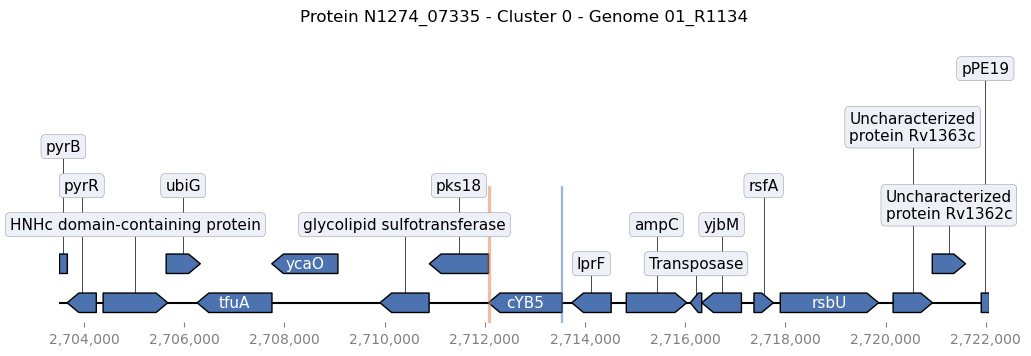

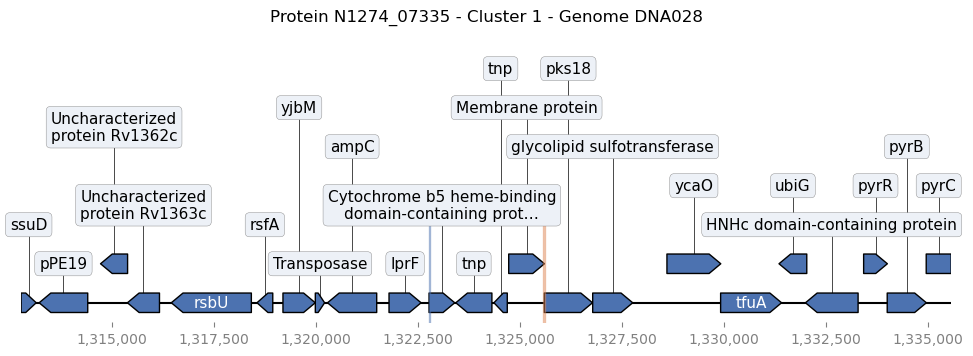

In [16]:
extract_plots(interesting_dfs_dict['N1274_07335'], 'N1274_07335')

/n/data1/hms/dbmi/baym/arya/miniconda/envs/denovo-mtbc/lib/python3.10/site-packages/dna_features_viewer/GraphicRecord/MatplotlibPlottableMixin.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, figsize=(figure_width, height))


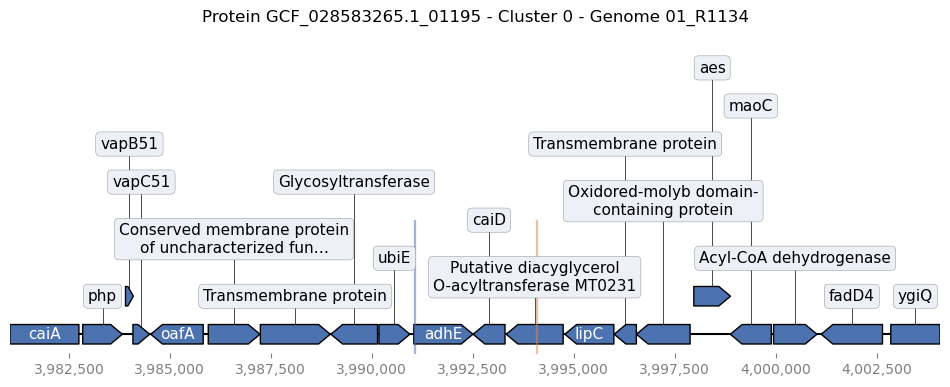

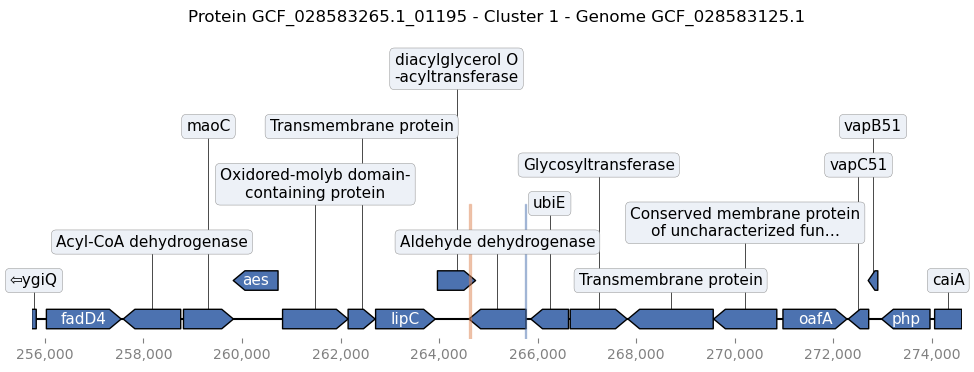

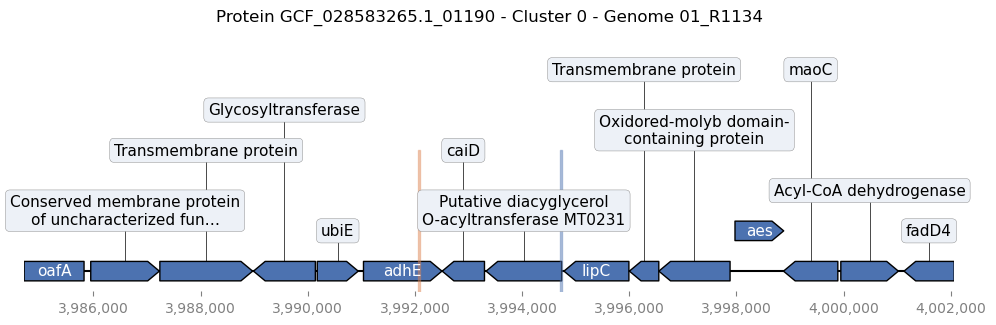

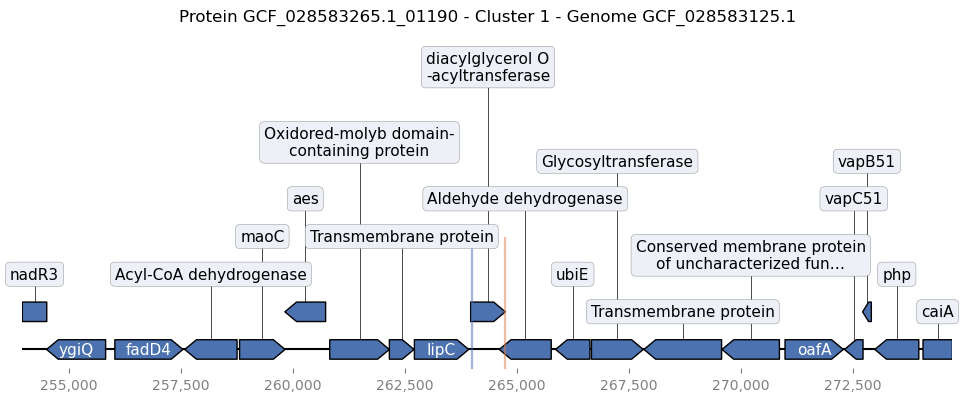

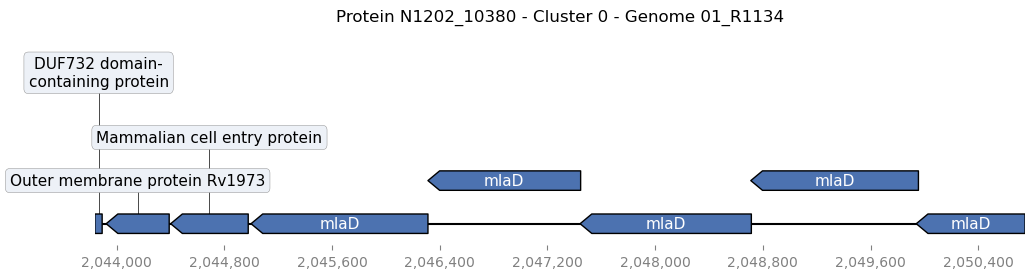

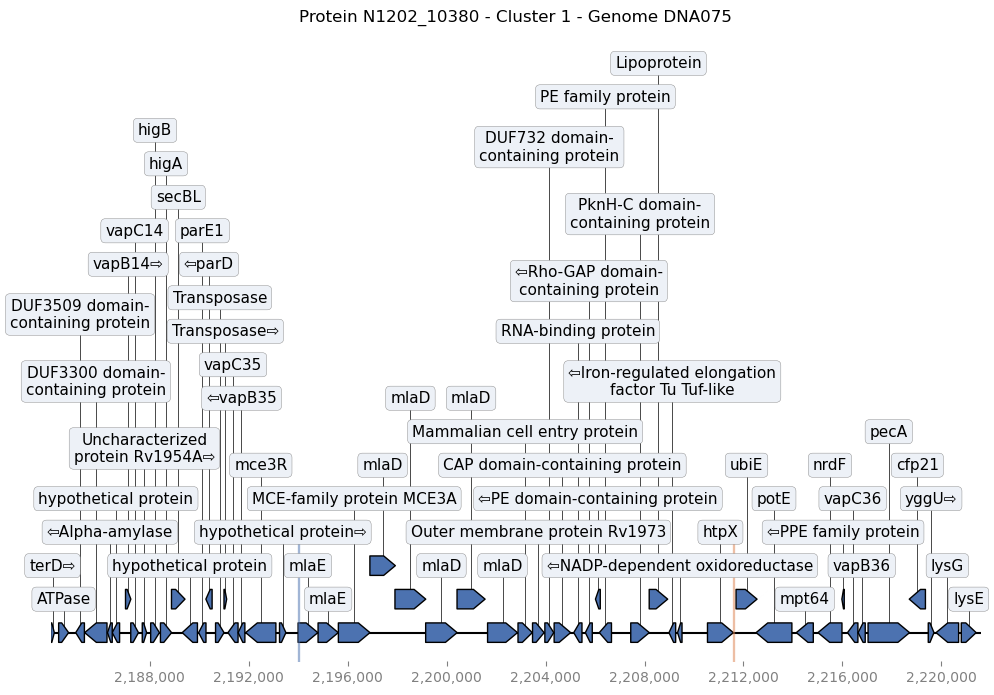

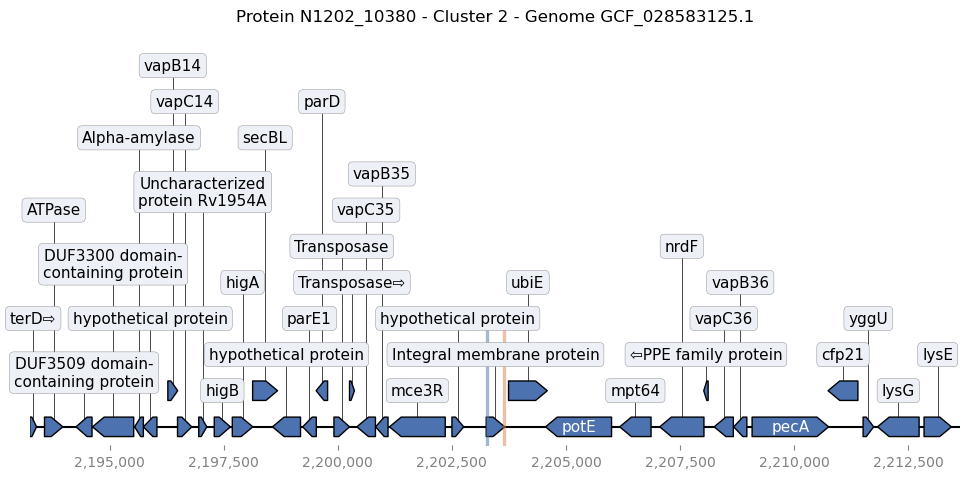

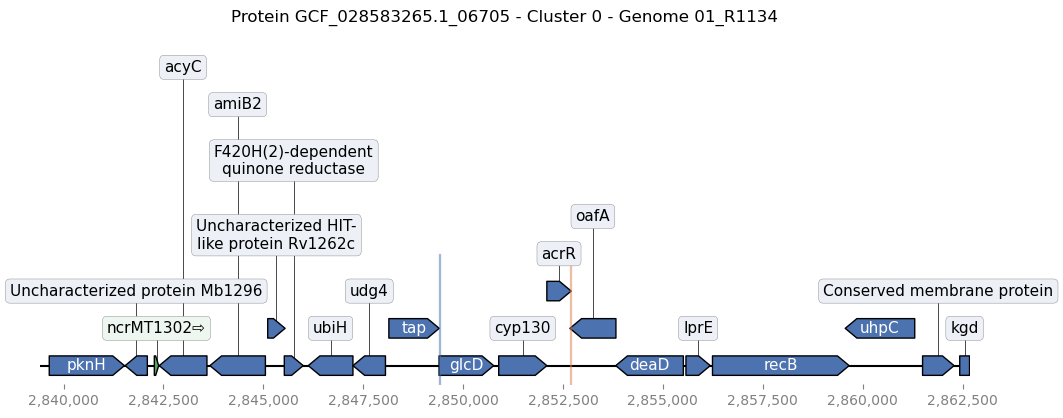

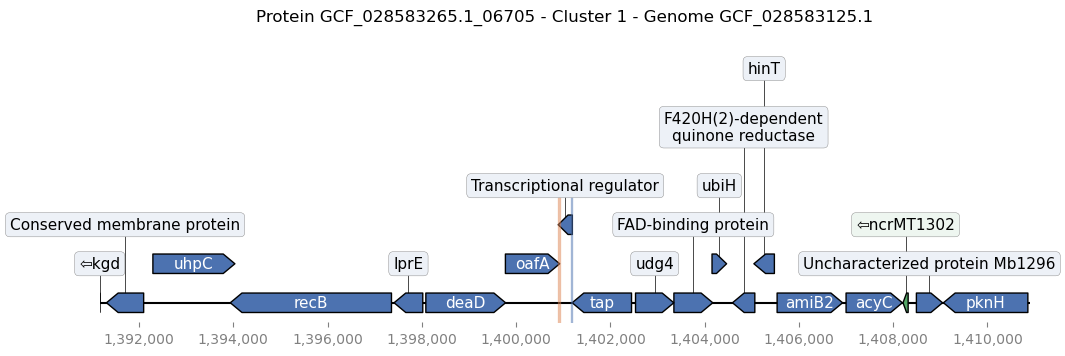

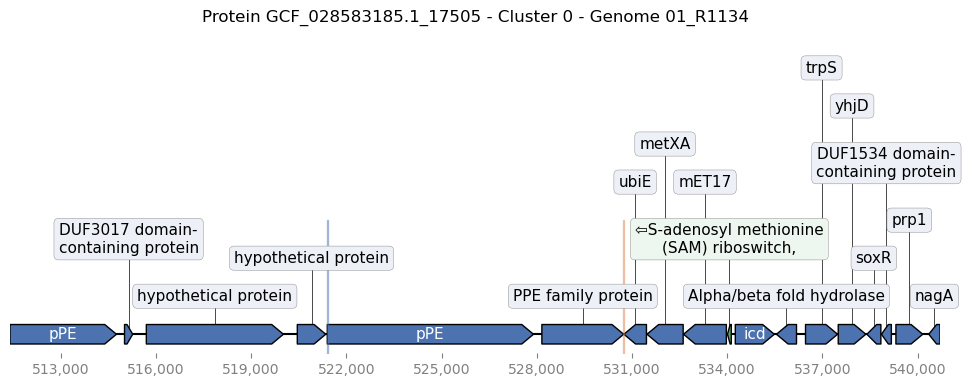

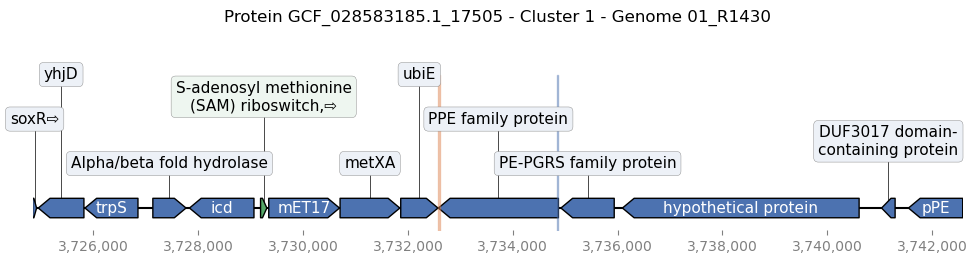

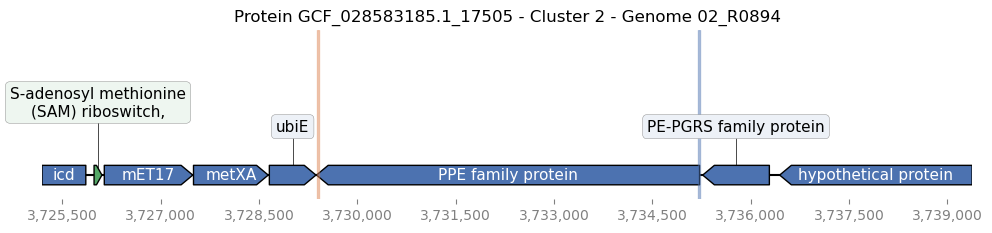

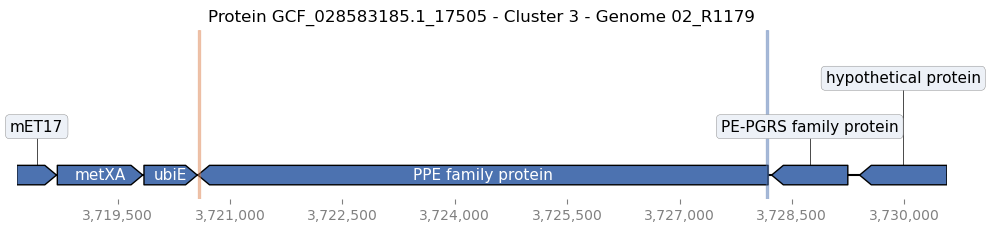

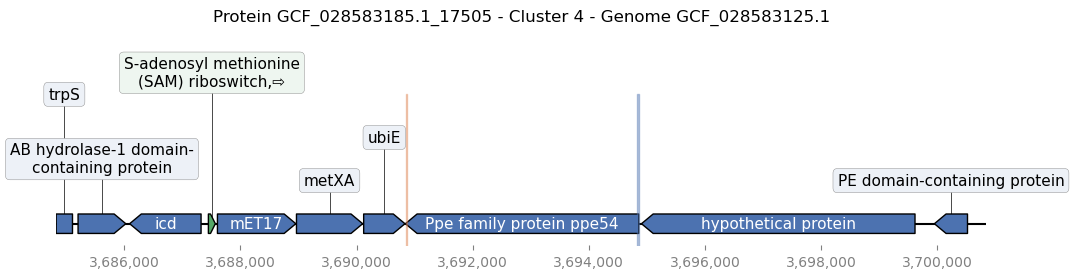

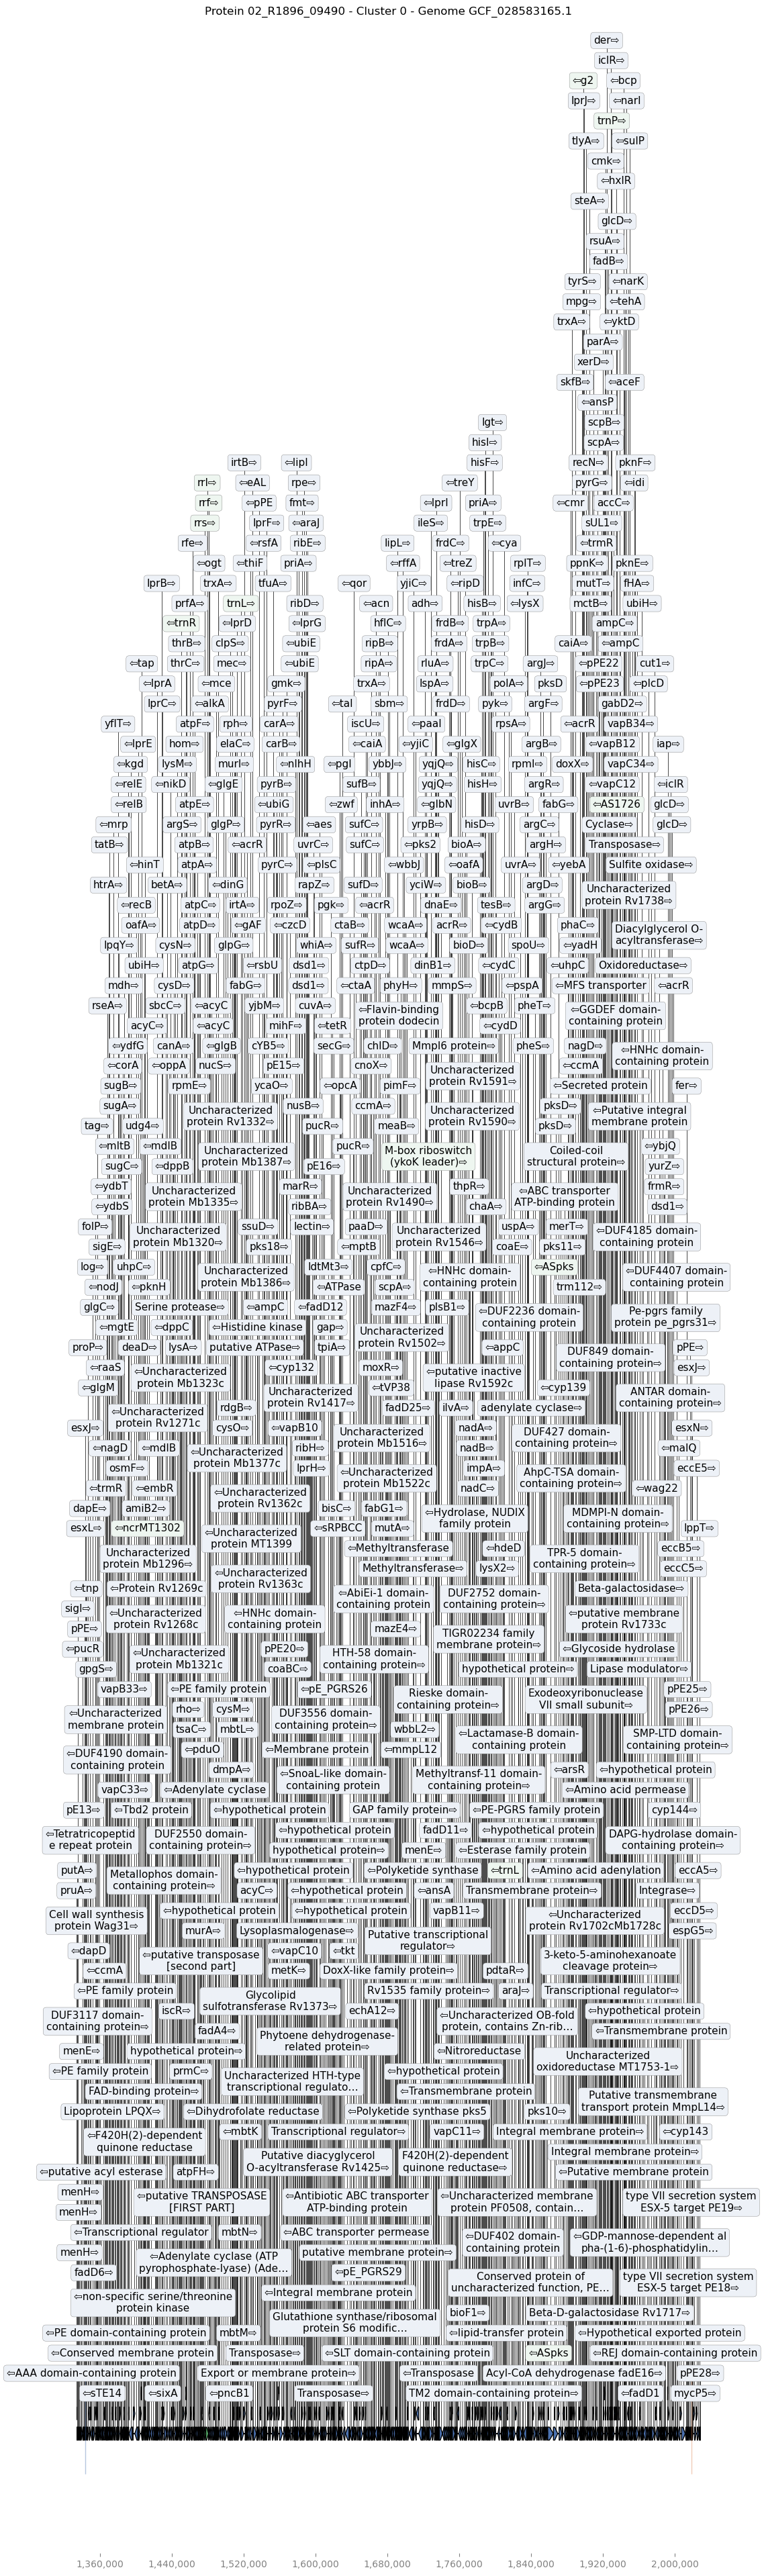

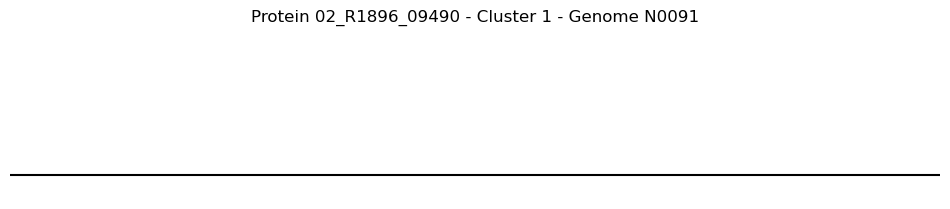

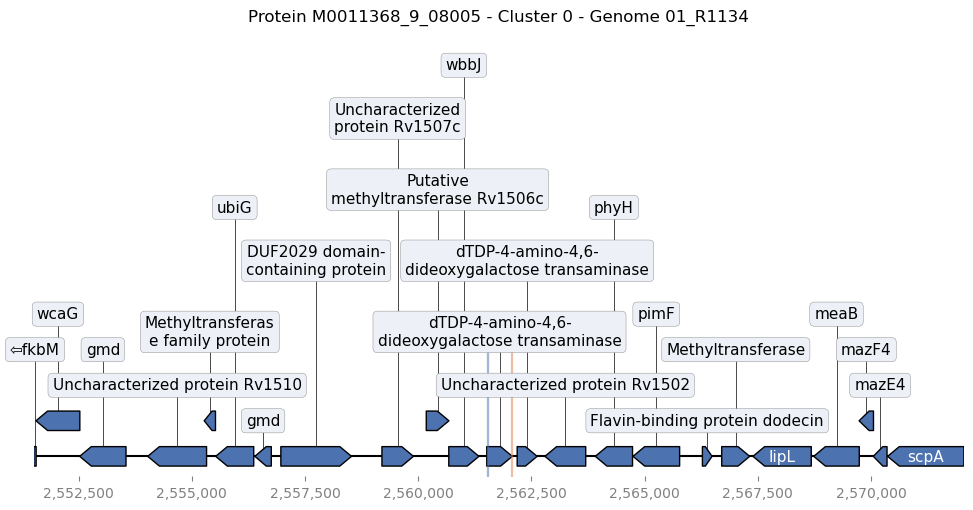

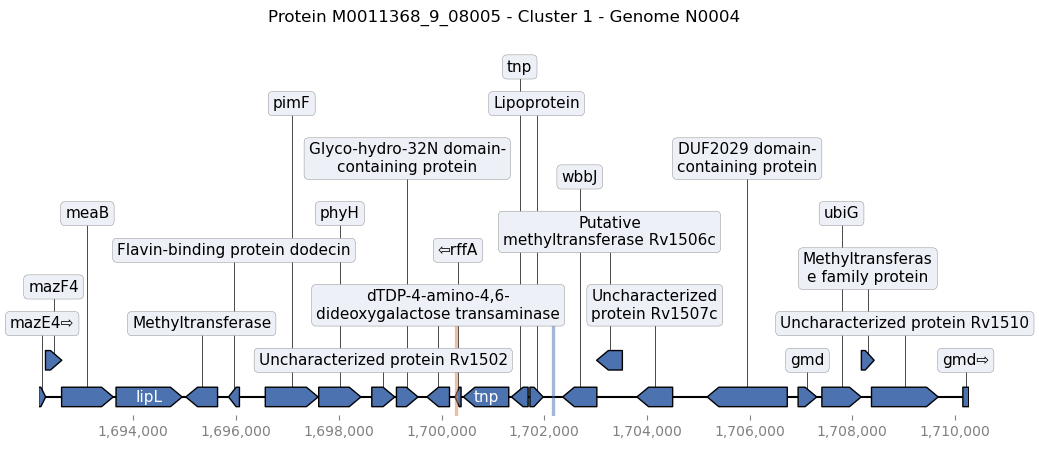

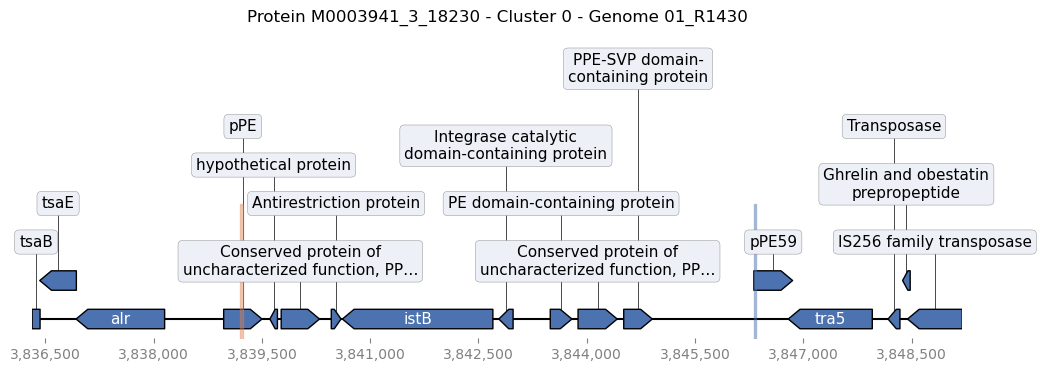

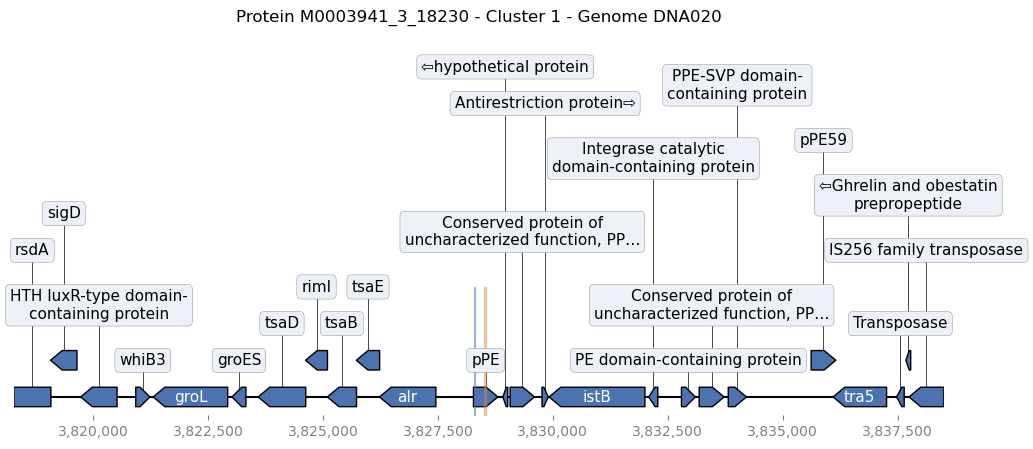

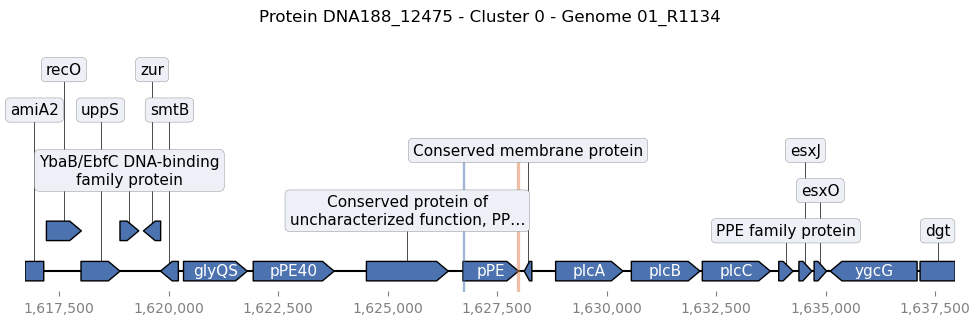

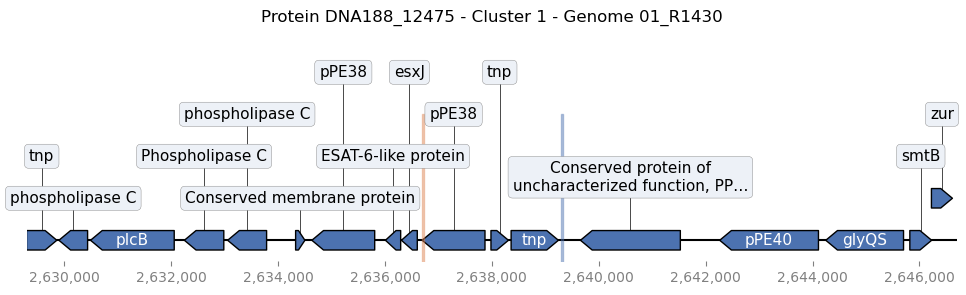

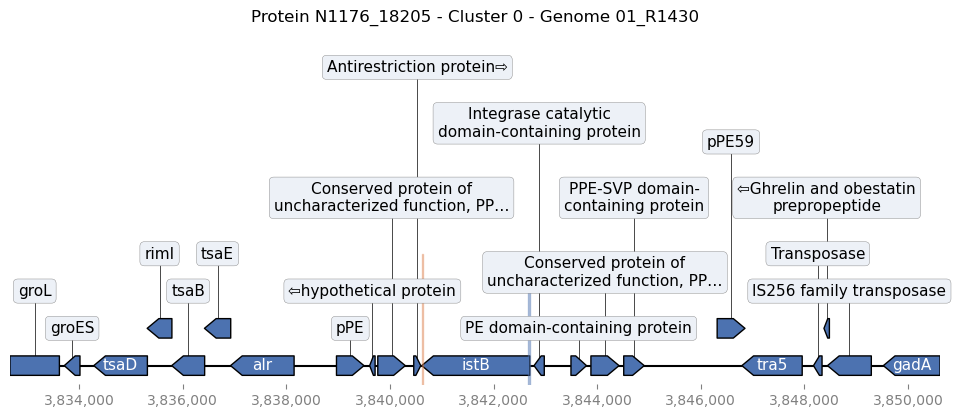

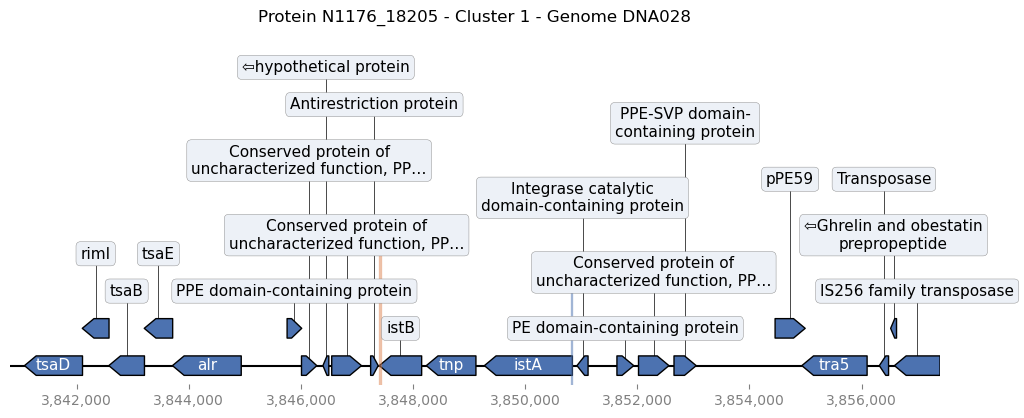

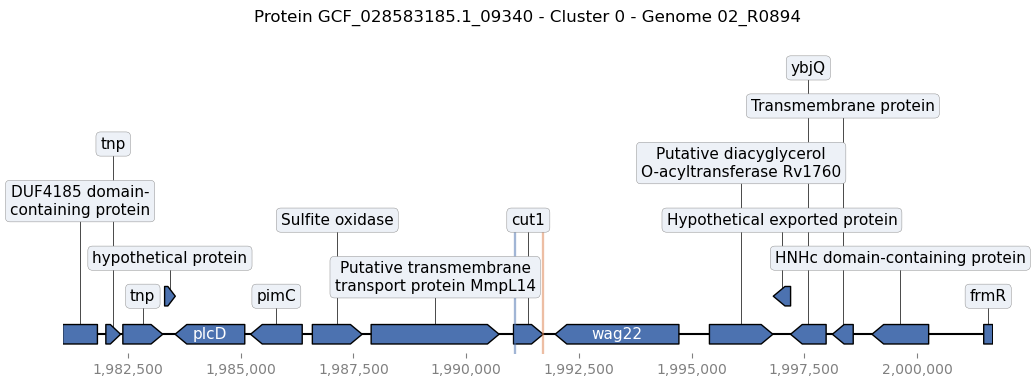

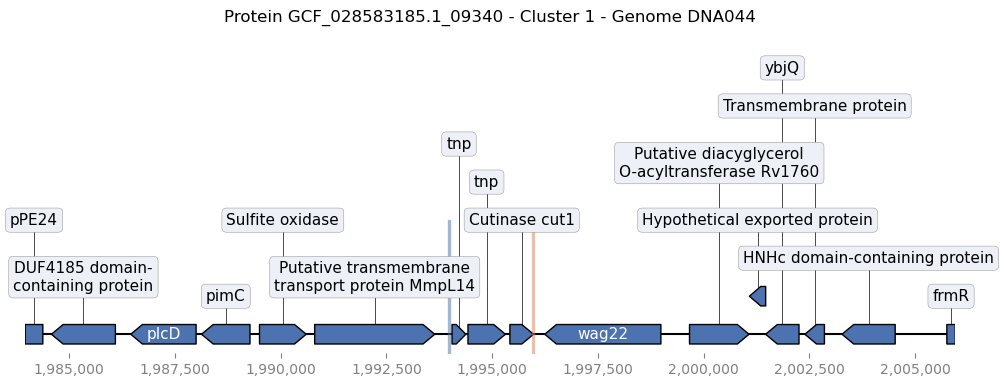

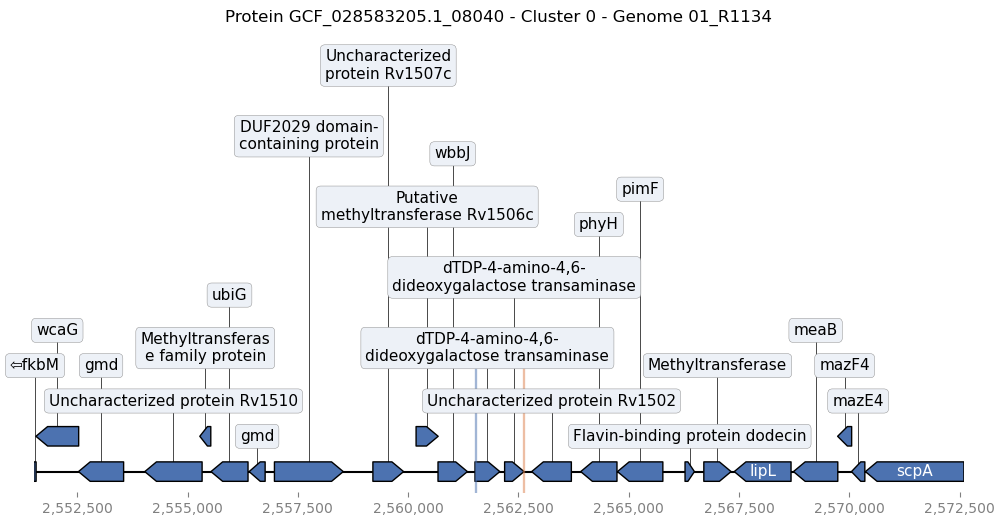

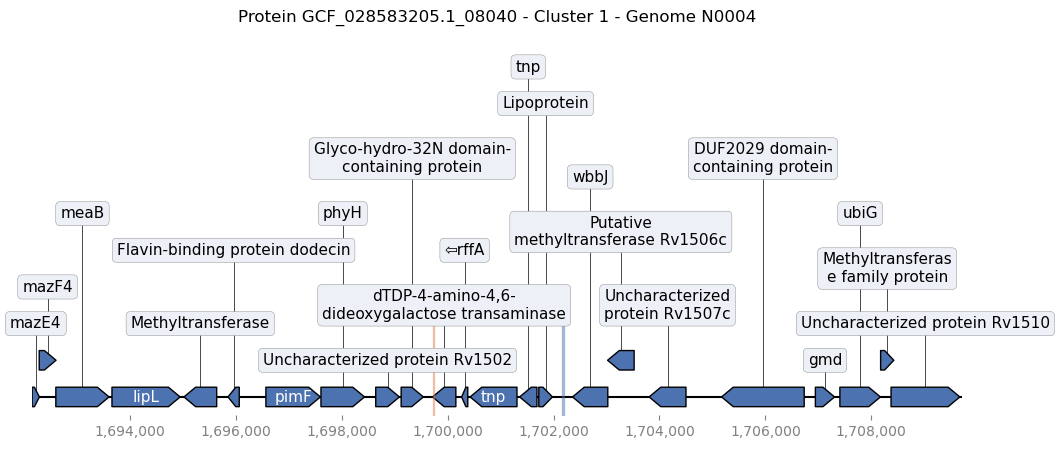

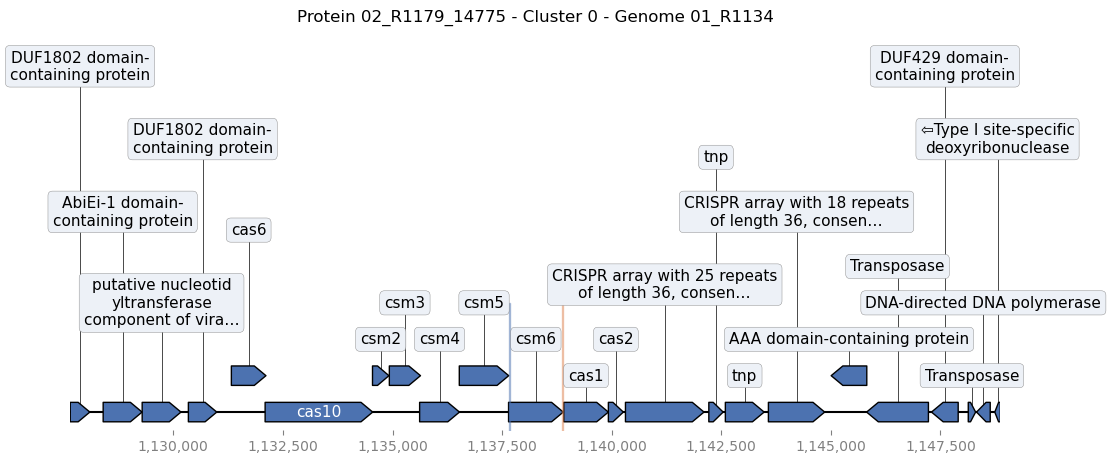

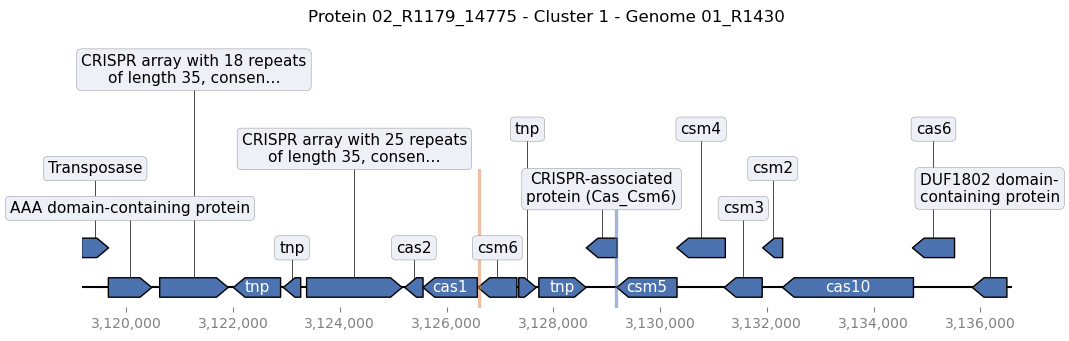

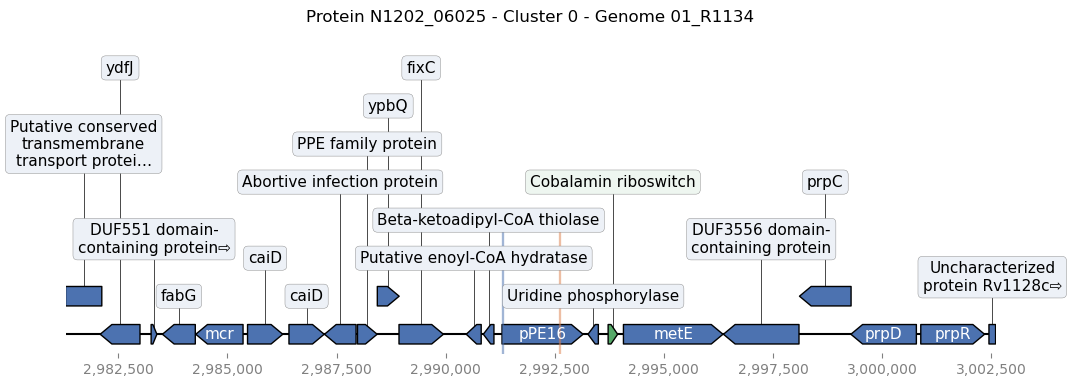

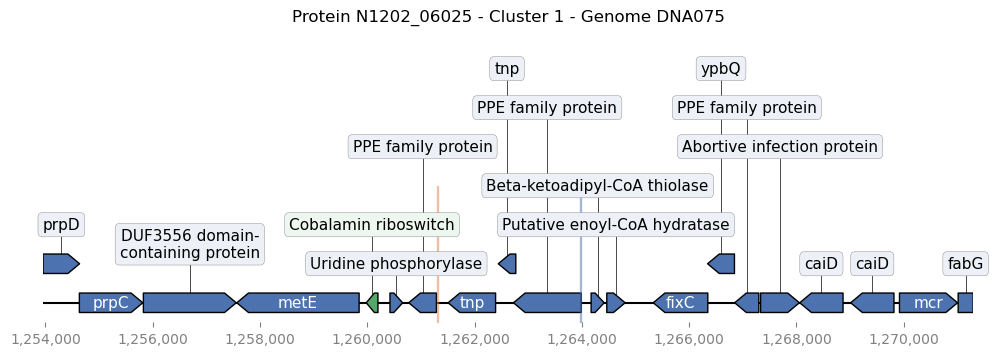

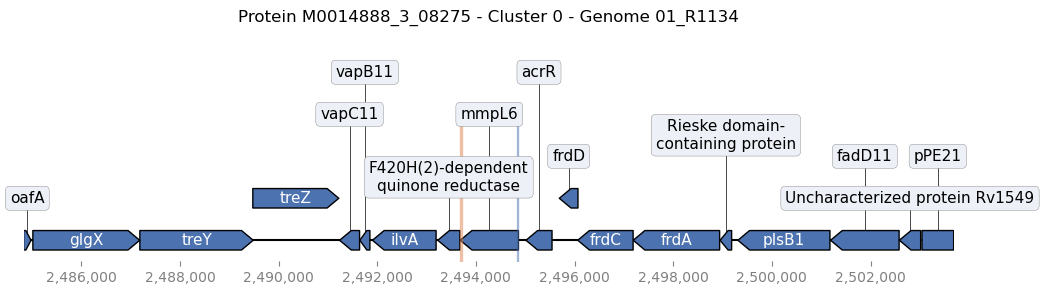

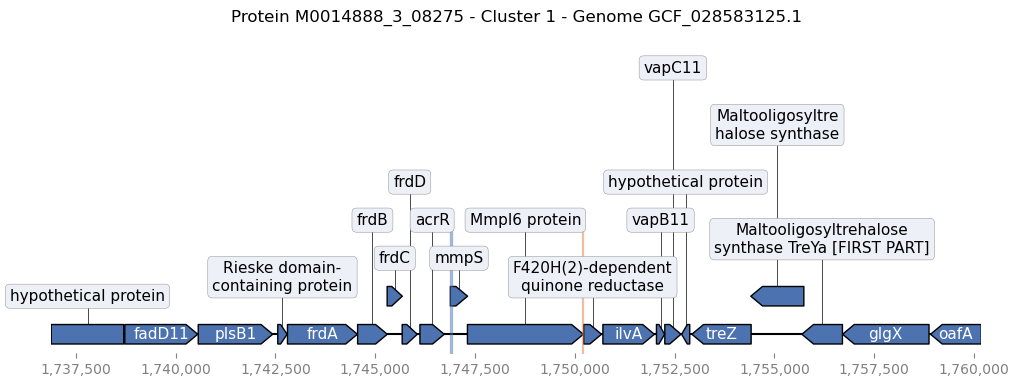

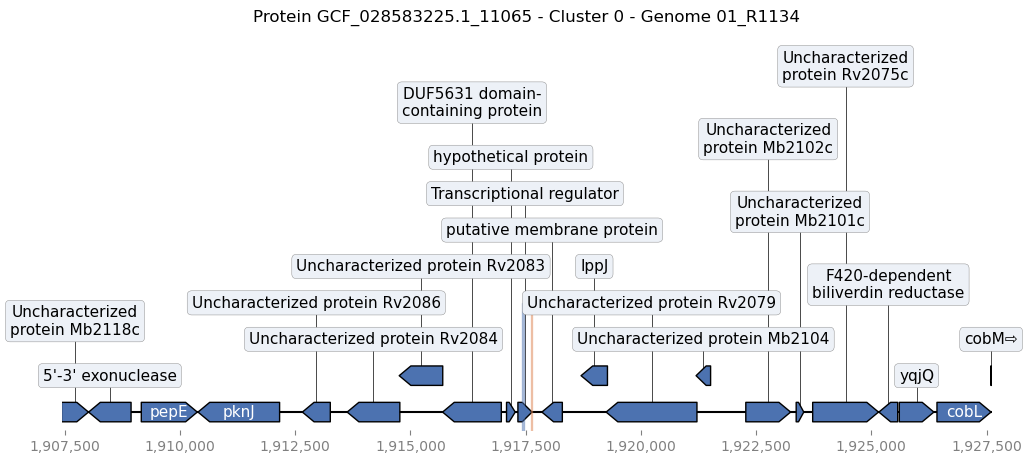

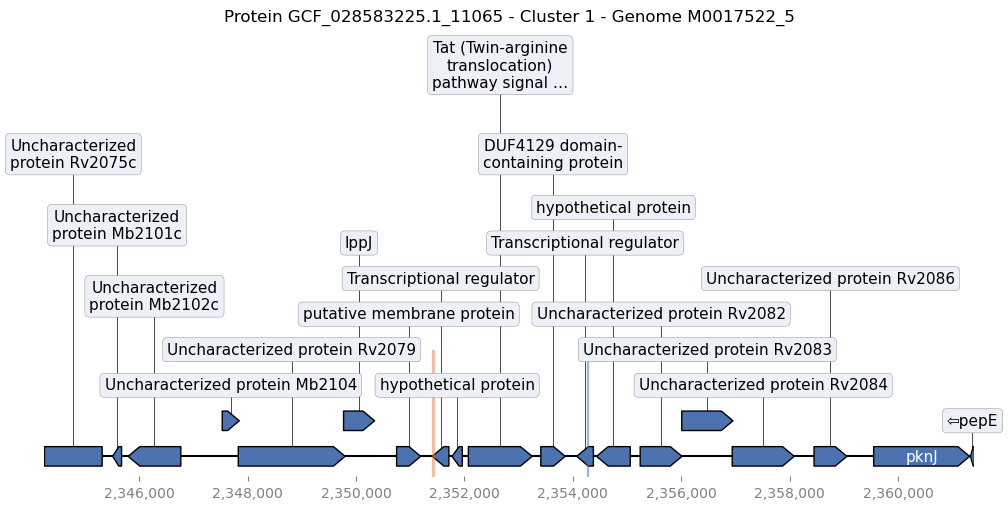

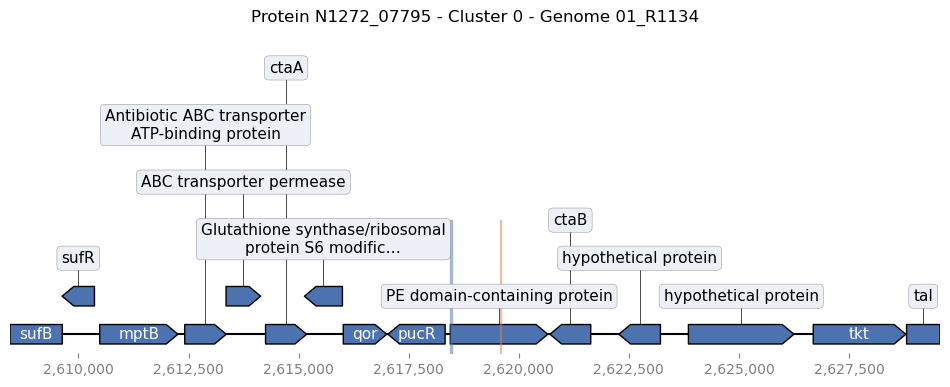

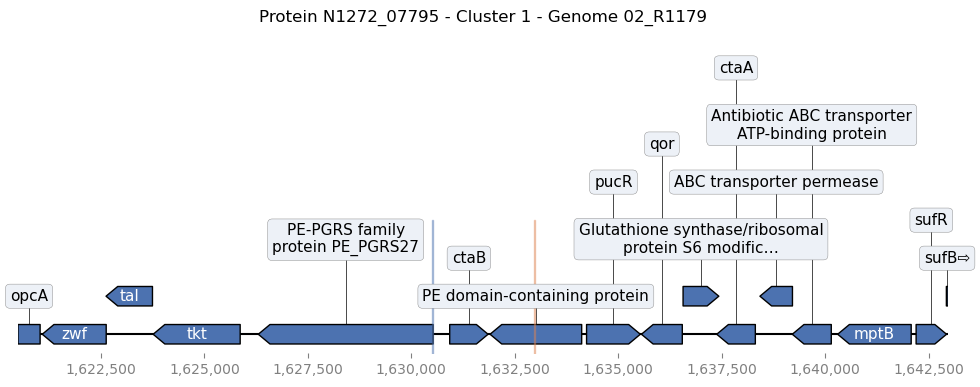

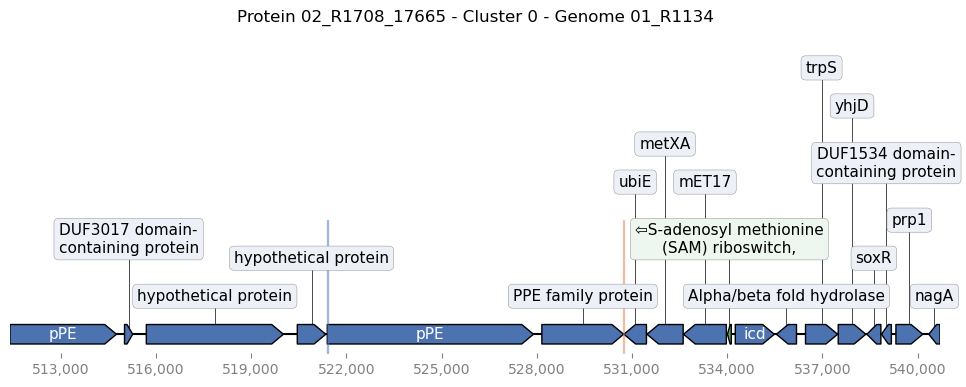

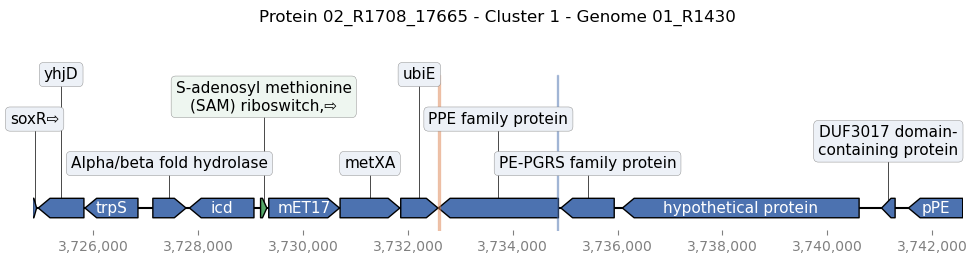

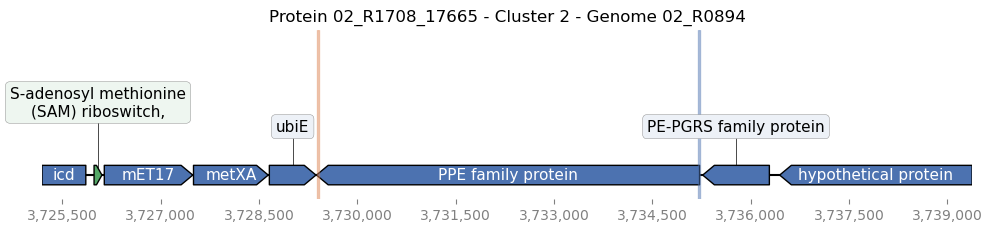

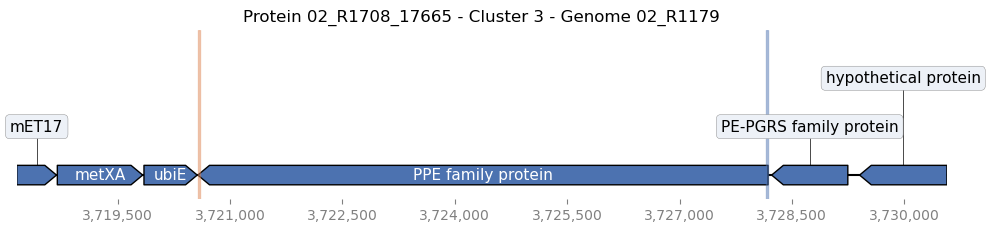

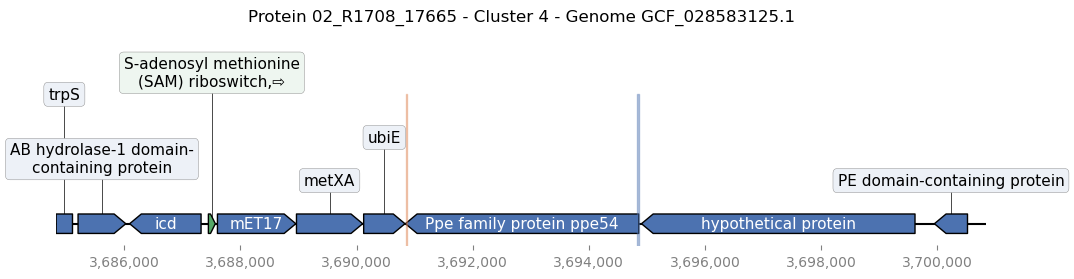

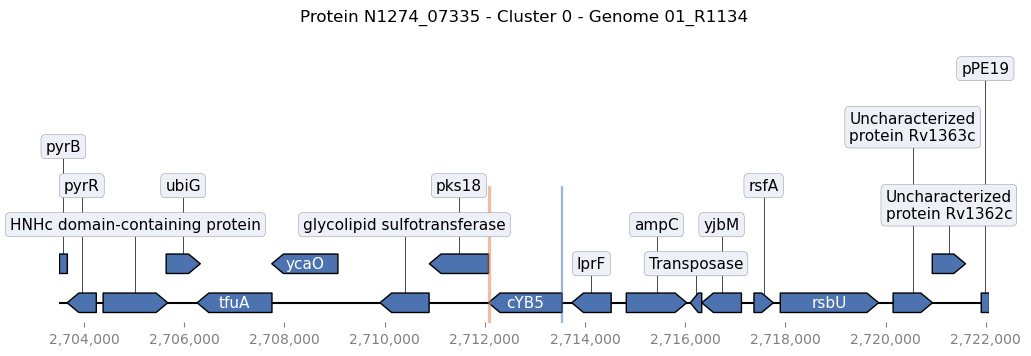

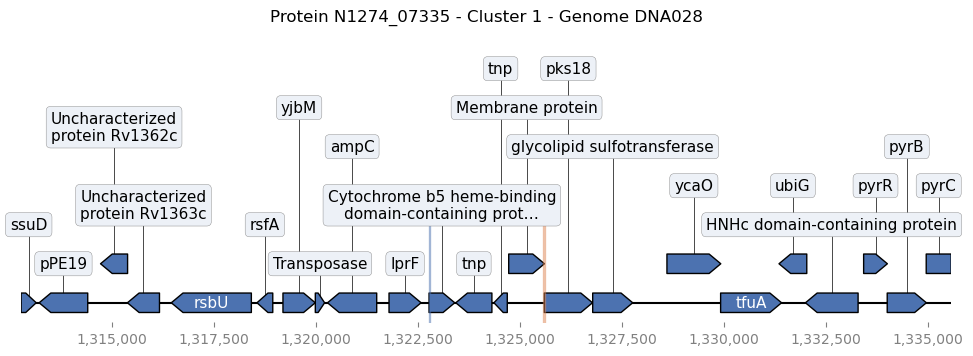

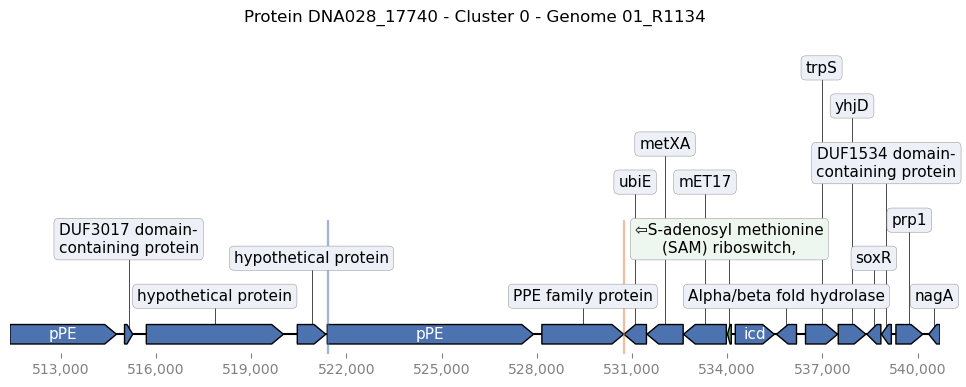

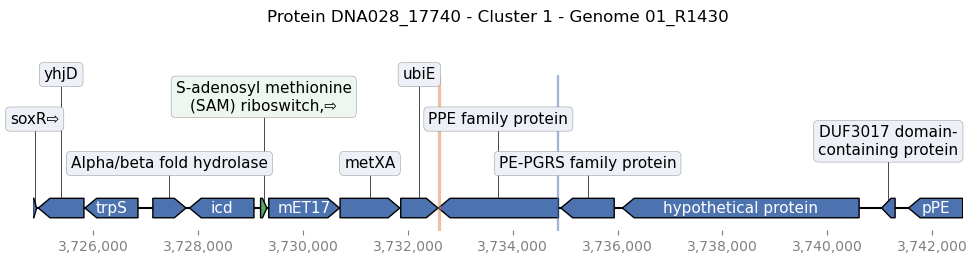

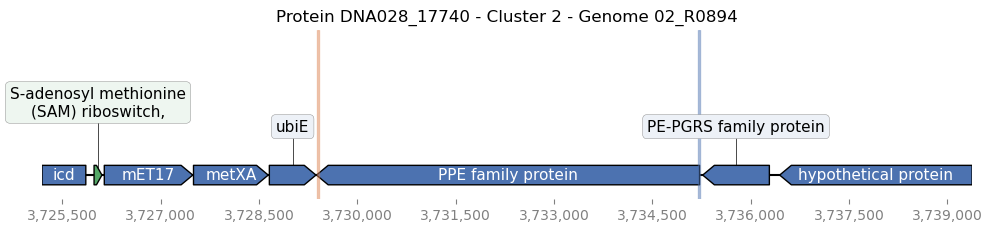

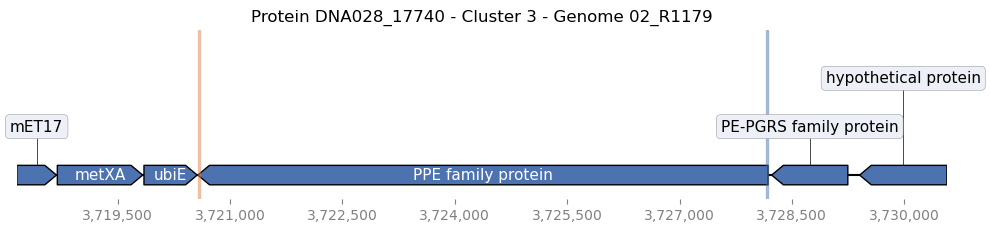

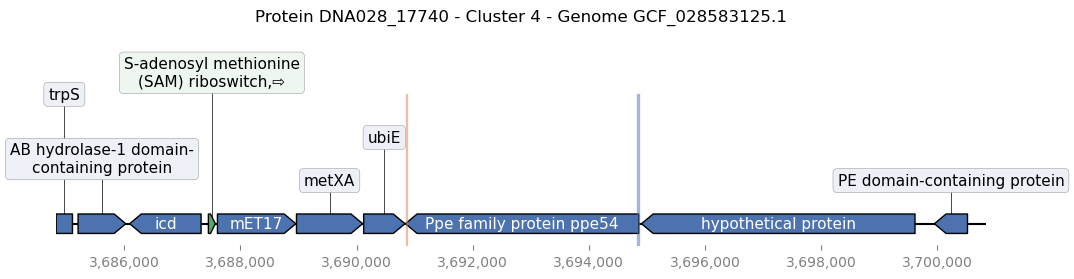

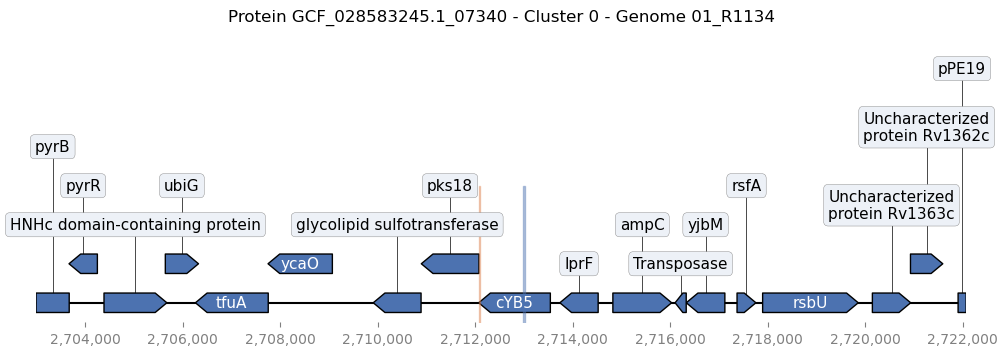

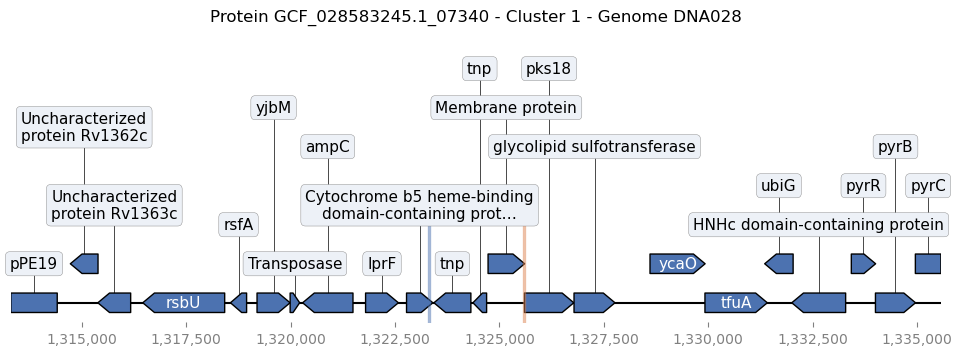

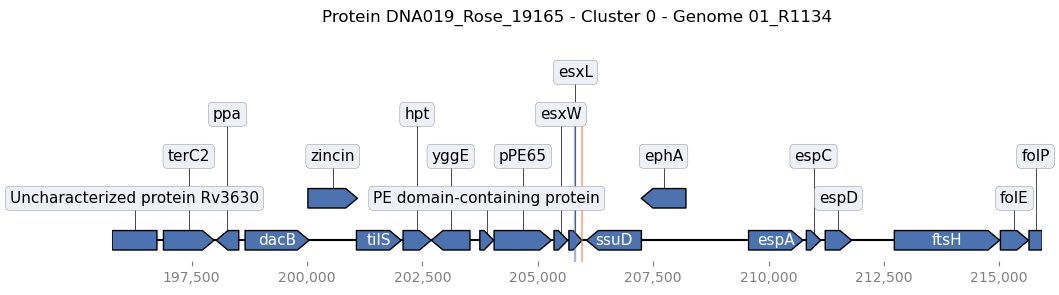

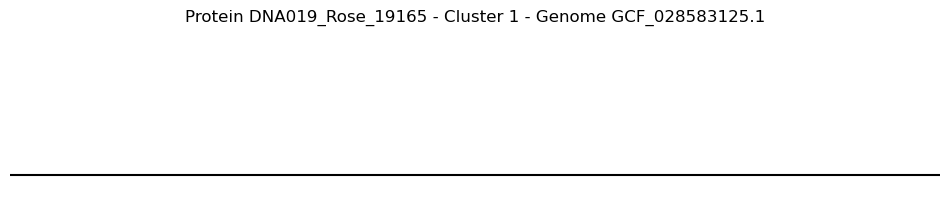

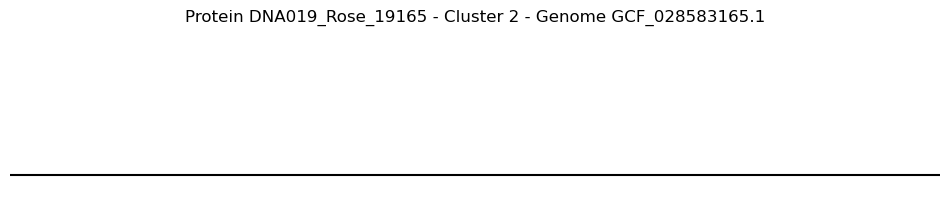

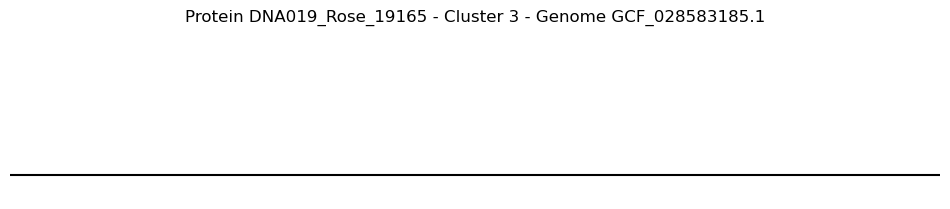

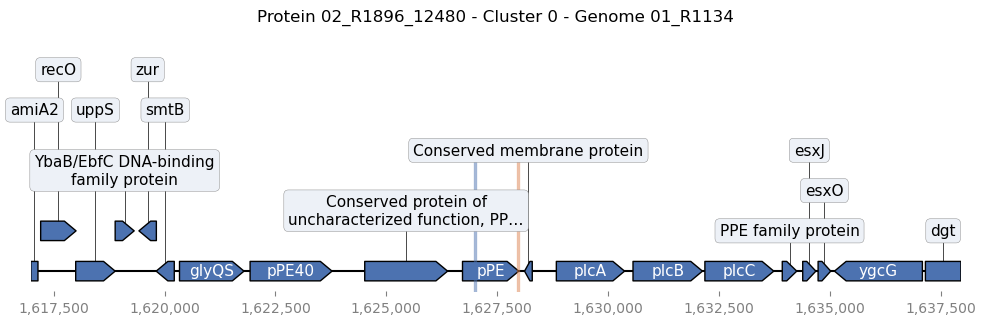

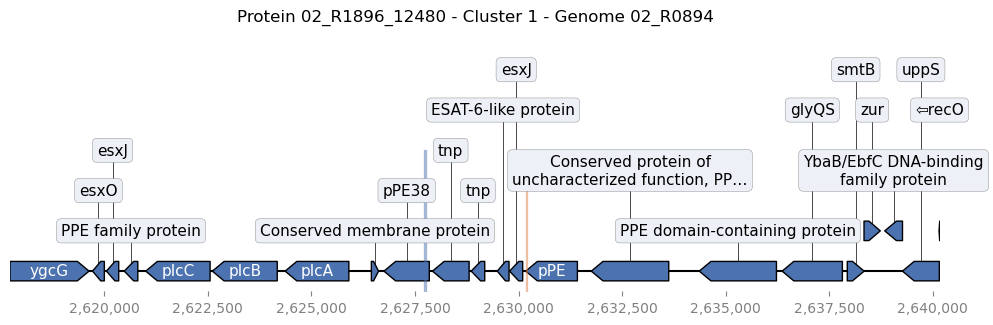

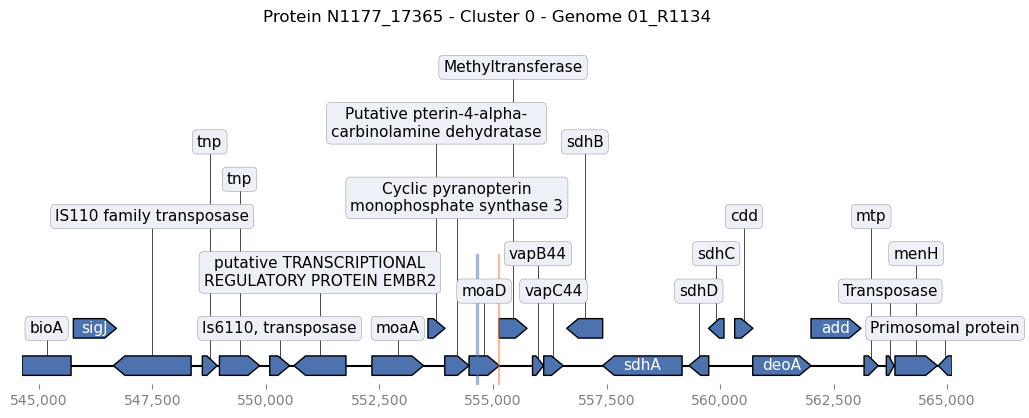

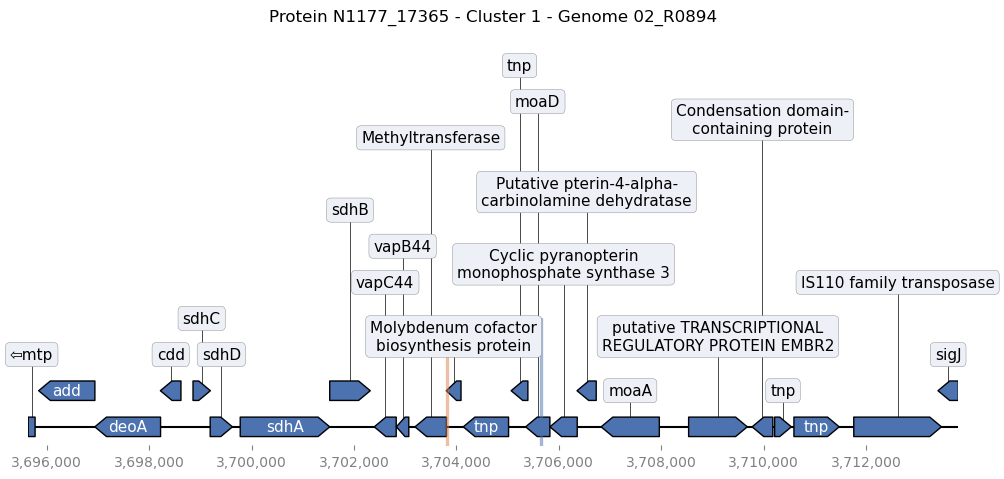

In [18]:
for passing_proteins in interesting_dfs_dict:
    extract_plots(interesting_dfs_dict[passing_proteins], passing_proteins)

In [ ]:

# Create a KDE plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=test, x="DISTANCE", hue="subsp", fill=True, common_norm=False, palette="tab10")
# plt.title(f"Density of { by subsp")
plt.show()


# Create the plot
plt.figure(figsize=(8, 6))

# Create the violin plots
sns.violinplot(x="subsp", y="DISTANCE", data=test, inner=None, palette="pastel")

# Overlay the data points using swarmplot
sns.swarmplot(x="subsp", y="DISTANCE", data=test, color='k', size=5)

plt.title("Distribution of DISTANCES by subsp")
plt.show()


In [ ]:
for i in bovis_distances:
    protein_name = os.path.basename(os.path.dirname(os.path.dirname(i)))
    j = pd.read_csv(i, delim_whitespace=True,
                  names=['EM','0','KMER','1','QUERY','DISTANCE','GENOME'])
    if j.shape[0] == 0: continue
    j['subsp'] = 'M. Tb'
    j.loc[j['GENOME'].str.contains('GCF_'), 'subsp'] = 'M. Bovis'
        
    # Create the violin plots
    sns.violinplot(x="subsp", y="DISTANCE", data=j, inner=None, palette="pastel")
    
    # Overlay the data points using swarmplot
    sns.swarmplot(x="subsp", y="DISTANCE", data=j, color='k', size=5)
    
    plt.title(f"Distribution of distances in {protein_name}")
    plt.show()
